# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
!pip install PyDrive
!pip install keras==2.2.4
!pip install tensorflow==1.13.1
!pip install git+https://github.com/darecophoenixx/wordroid.sblo.jp

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 92.5MB 74kB/s 
     |████████████████████████████████| 3.2MB 46.4MB/s 
     |████████████████████████████████| 368kB 49.7MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0
  Cloning https://github.com/darecophoenixx/wordroid.sblo.jp to /tmp/pip-req-build-gz4j89ls
  Running command git clone -q https://github.com/darecophoenixx/wordroid.sblo.jp /tmp/pip-req-build-gz4j89ls
  Created wheel for wordroid.sblo.

In [2]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(1)
np.random.seed(1)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,self.imsize)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (0.5)*ssim(individual.reshape(28,28),self.img.reshape(28,28)) 

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = 1-ssim(self.X_best.reshape(28,28),self.img.reshape(28,28))
        individual = self.X_best.reshape(1,self.imsize)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"16oao6c9BTb33sbaFzCDJ1sGQn4Z0ILS7"}) 
downloaded.GetContentFile('rbfnn_v2.h5')   

num_lm0 = 100
num_lm = num_lm0 * 10
init_wgt = np.zeros(((1000, 784)))

inp = Input(shape=(28*28,), name='inp')
oup = GaussianKernel(num_lm, 28*28,
                     kernel_gamma='auto', weights=[init_wgt],
                     name='gkernel1')(inp)
oup = Dense(10, activation='softmax')(oup)
model = Model(inp, oup)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("rbfnn_v2.h5")

Instructions for updating:
Colocations handled automatically by placer.


# Prepare Data

In [0]:
import pickle
file_ = open('subset', 'rb')
dump = pickle.load(file_)
adversarial = pickle.load(file_)
dump = pickle.load(file_)
adversarial_y = pickle.load(file_)
file_.close()
del dump

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 20, #50 (5) #200 (1)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2) (it was 2000)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4) (it was 125)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


25  :  0.7150613047320399 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


50  :  0.7562538511141846 25
75  :  0.7518943926113186 25
100  :  0.7446527114461643 25
125  :  0.7555278648291308 25
150  :  0.7559624061024001 25
175  :  0.7637767748427722 25
200  :  0.77036307127773 25
225  :  0.77036307127773 25
250  :  0.7789179341475314 25
275  :  0.7814420980429514 25
300  :  0.7831303152768525 25
325  :  0.7836501376635121 25
350  :  0.7862261915766484 25
375  :  0.7904177720344665 25
400  :  0.7983916515565395 25
425  :  0.7996195276727034 25
450  :  0.7996195276727034 25
475  :  0.7999843525694862 25
500  :  0.8037439114686549 25
525  :  0.8076301377563819 25
550  :  0.8077189514180398 25
575  :  0.8101357366241888 25
600  :  0.8107562862993736 25
625  :  0.8113069764664054 25
650  :  0.8112980017185047 25
675  :  0.811969665628923 25
700  :  0.811969665628923 25
725  :  0.8127536250579269 25
750  :  0.8127532061527416 25
775  :  0.8137578621199961 25
800  :  0.8143141584865315 25
825  :  0.8146401007834726 25
850  :  0.8150681925267987 25
875  :  0.81590839

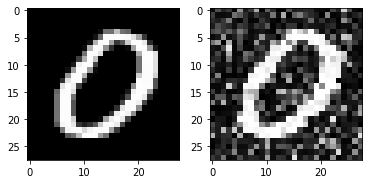

25  :  0.3967056180463197 25
50  :  0.7487878974640512 25
75  :  0.709896163636403 25
100  :  0.7307553031187148 25
125  :  0.7120906226486194 25
150  :  0.7091332741853573 25
175  :  0.7341729541953756 25
200  :  0.7419903964524226 25
225  :  0.7467766726204241 25
250  :  0.7485198794997667 25
275  :  0.7539729714893297 25
300  :  0.758074664559794 25
325  :  0.7615804212537702 25
350  :  0.7726904820250264 25
375  :  0.77321718419714 25
400  :  0.77321718419714 25
425  :  0.77321718419714 25
450  :  0.7763108327295581 25
475  :  0.7793813965376193 25
500  :  0.7808049158217696 25
525  :  0.7810375715847877 25
550  :  0.7826025435450856 25
575  :  0.7831258199432147 25
600  :  0.7844270698942806 25
625  :  0.7844270698942806 25
650  :  0.7891464518632514 25
675  :  0.7895990686049188 25
700  :  0.7897256135761578 25
725  :  0.7897256135761578 25
750  :  0.7897256135761578 25
775  :  0.7923516793618118 25
800  :  0.7928573124314754 25
825  :  0.7931569361959963 25
850  :  0.79577259469

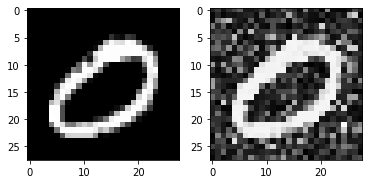

25  :  0.671627616342632 25
50  :  0.7128423674304816 25
75  :  0.7006430695707677 25
100  :  0.7278387915590674 25
125  :  0.7452542142083396 25
150  :  0.741005905412021 25
175  :  0.7708831867214206 25
200  :  0.7733006484005371 25
225  :  0.7858131975662941 25
250  :  0.7894052675595842 25
275  :  0.7908898394178985 25
300  :  0.7920466544066633 25
325  :  0.7923532219924708 25
350  :  0.7984702977119518 25
375  :  0.8038271061480731 25
400  :  0.8036991896802486 25
425  :  0.80585909407365 25
450  :  0.8065008241494803 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


475  :  0.8089389197720831 25
500  :  0.8088351219602817 25
525  :  0.8103592465919194 25
550  :  0.8107514881862805 25
575  :  0.8117400425405203 25
600  :  0.812011051596381 25
625  :  0.8129508225022977 25
650  :  0.8135560478896722 25
675  :  0.8140323917545056 25
700  :  0.814444947524888 25
725  :  0.814996725855959 25
750  :  0.8158657571424777 25
775  :  0.8170744556193104 25
800  :  0.8168413923527061 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide


825  :  0.8172079799589212 25
850  :  0.8172089994025249 25
875  :  0.8172089994025249 25
900  :  0.8172512845033053 25
925  :  0.8174117333254209 25
950  :  0.8174061897009178 25
975  :  0.8174061897009178 25
1000  :  0.8174507736417189 25
Time:  110.9274652004242  seconds
Predicted class:  [5]


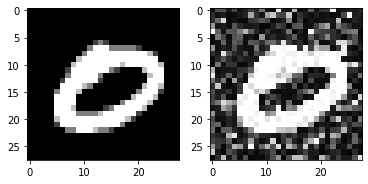

25  :  0.4677813709538695 25
50  :  0.6672589710720398 25
75  :  0.5213227693133413 25
100  :  0.6570199656635302 25
125  :  0.6637039491946897 25
150  :  0.690046025561492 25
175  :  0.7044752215067691 25
200  :  0.7080983304854385 25
225  :  0.7093464310610258 25
250  :  0.7284175983195034 25
275  :  0.7244295195903682 25
300  :  0.725639404540728 25
325  :  0.7274771460832096 25
350  :  0.7314934367555814 25
375  :  0.7372139068897792 25
400  :  0.7377479027666441 25
425  :  0.7377479027666441 25
450  :  0.7430483122472338 25
475  :  0.7485964522402153 25
500  :  0.7497166919242957 25
525  :  0.7533540796547868 25
550  :  0.7545119878672439 25
575  :  0.7580632639058704 25
600  :  0.7580868799590597 25
625  :  0.7582646622264652 25
650  :  0.7582772607694203 25
675  :  0.7616746601476545 25
700  :  0.7616746601476545 25
725  :  0.7619629411991724 25
750  :  0.762581366148072 25
775  :  0.7643472833364446 25
800  :  0.7650357531917116 25
825  :  0.767986126215975 25
850  :  0.7680051

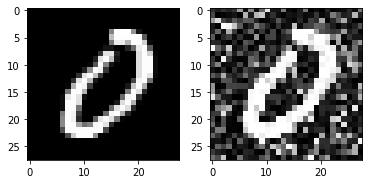

25  :  0.7697535428675462 25
50  :  0.7825040278106784 25
75  :  0.7766087474209066 25
100  :  0.7569006988695068 25
125  :  0.7873890932196399 25
150  :  0.792219792877157 25
175  :  0.7997105920992462 25
200  :  0.8065694944394878 25
225  :  0.8076763732488866 25
250  :  0.8076763732488866 25
275  :  0.8110008360933341 25
300  :  0.8110008360933341 25
325  :  0.8127393114374304 25
350  :  0.8127629410032345 25
375  :  0.8170059050427175 25
400  :  0.8170059050427175 25
425  :  0.8177009788279477 25
450  :  0.8202464737420245 25
475  :  0.8202085636027863 25
500  :  0.820980878943395 25
525  :  0.820980878943395 25
550  :  0.8225661489220445 25
575  :  0.8230482534232972 25
600  :  0.8245293333387198 25
625  :  0.8245337880895445 25
650  :  0.8250351891518439 25
675  :  0.825880554065878 25
700  :  0.825880554065878 25
725  :  0.8261302603620011 25
750  :  0.827151493478574 25
775  :  0.8275072356819535 25
800  :  0.8288014120355138 25
825  :  0.8287854326326496 25
850  :  0.829075903

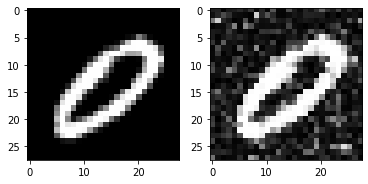

25  :  0.7626054846527366 25
50  :  0.7707097117542296 25
75  :  0.7639105267439874 25
100  :  0.7629989896619946 25
125  :  0.7691906059127351 25
150  :  0.7806346997435454 25
175  :  0.7857724843647804 25
200  :  0.7888131421503957 25
225  :  0.7975981385352187 25
250  :  0.8000831392258809 25
275  :  0.8046412409225951 25
300  :  0.809504609162576 25
325  :  0.8131614864420107 25
350  :  0.8162695091045105 25
375  :  0.8162695091045105 25
400  :  0.8183954275398859 25
425  :  0.818356148275637 25
450  :  0.8208192919401172 25
475  :  0.8207022558222983 25
500  :  0.8207022558222983 25
525  :  0.8209205309368782 25
550  :  0.8221597705669803 25
575  :  0.8231970980324266 25
600  :  0.8240640950919258 25
625  :  0.8245077990077447 25
650  :  0.8251023127319863 25
675  :  0.825099874847394 25
700  :  0.8252874473571867 25
725  :  0.8256806150699967 25
750  :  0.8256859963013132 25
775  :  0.8271013325275103 25
800  :  0.827119607216575 25
825  :  0.827119607216575 25
850  :  0.82711960

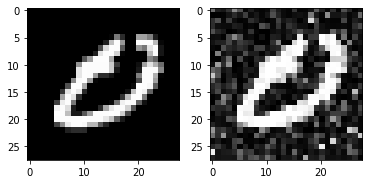

25  :  0.03035702195607487 25
50  :  0.6219628478013358 25
75  :  0.1156840096310518 25
100  :  0.30521863762703894 25
125  :  0.6303415734362257 25
150  :  0.47815781950731007 25
175  :  0.4490029631428059 25
200  :  0.5243516405397607 25
225  :  0.6421941690674704 25
250  :  0.2236614225298849 25
275  :  0.5353568793071755 25
300  :  0.7347451522661594 25
325  :  0.7463294347936457 25
350  :  0.7472417265078826 25
375  :  0.7497506061204204 25
400  :  0.7497506061204204 25
425  :  0.7566002385787585 25
450  :  0.762805406273969 25
475  :  0.7643303516393449 25
500  :  0.7725375377516239 25
525  :  0.7836568525284313 25
550  :  0.7828691509990641 25
575  :  0.7828691509990641 25
600  :  0.783465862964444 25
625  :  0.7852332872576039 25
650  :  0.7861305437041066 25
675  :  0.7865071424745749 25
700  :  0.786616700038782 25
725  :  0.7872941832156519 25
750  :  0.7883060297656309 25
775  :  0.7889184157676976 25
800  :  0.789374923764459 25
825  :  0.7894343523013617 25
850  :  0.7894

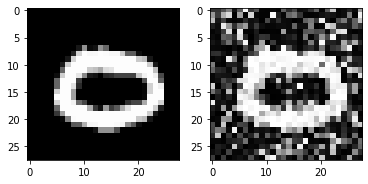

25  :  -0.11046269087760885 25
50  :  -0.11046269087760885 25
75  :  -0.10973426926446078 25
100  :  -0.10929657659221992 25
125  :  -0.10950096794290975 25
150  :  -0.10705040077512185 25
175  :  -0.10705040077512185 25
200  :  -0.10705040077512185 25
225  :  -0.10705040077512185 25
250  :  -0.10659274977889893 25
275  :  -0.10595870098405996 25
300  :  -0.10554250404954779 25
325  :  -0.10558056354960171 25
350  :  -0.10531426935892751 25
375  :  -0.10531426935892751 25
400  :  -0.10443876901869065 25
425  :  -0.10426234875696738 25
450  :  -0.10426234875696738 25
475  :  -0.10400896830909401 25
500  :  -0.10400896830909401 25
525  :  -0.10390321602098601 25
550  :  -0.10297035626783624 25
575  :  -0.10297777178237905 25
600  :  -0.10297777178237905 25
625  :  -0.10291931599268994 25
650  :  -0.1028052397098102 25
675  :  -0.10282845407324015 25
700  :  -0.10282845407324015 25
725  :  -0.1024983034250237 25
750  :  -0.10249682706004554 25
775  :  -0.1023620256964824 25
800  :  -0.102

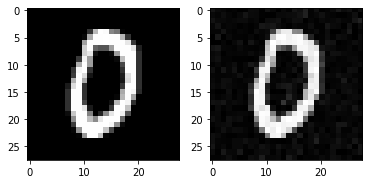

25  :  0.024313805354919116 25
50  :  0.540228147607758 25
75  :  0.5439579604682865 25
100  :  0.5724942948822911 25
125  :  0.6111393815037983 25
150  :  0.6139133286222205 25
175  :  0.6081410298855893 25
200  :  0.6089223096003203 25
225  :  0.6045115593662992 25
250  :  0.6175012345599321 25
275  :  0.6175012345599321 25
300  :  0.6175012345599321 25
325  :  0.6427105164928365 25
350  :  0.6429699534142665 25
375  :  0.6657469442636028 25
400  :  0.6749578898812529 25
425  :  0.6816244921696311 25
450  :  0.6816244921696311 25
475  :  0.6882078161721117 25
500  :  0.6924273793820729 25
525  :  0.6924273793820729 25
550  :  0.6979636811514289 25
575  :  0.7034514104450225 25
600  :  0.7040032795005954 25
625  :  0.7040032795005954 25
650  :  0.7040032795005954 25
675  :  0.704648226954399 25
700  :  0.7060818608104672 25
725  :  0.7060818608104672 25
750  :  0.7098272796769598 25
775  :  0.71010036337816 25
800  :  0.711631781639402 25
825  :  0.7120549802283489 25
850  :  0.712449

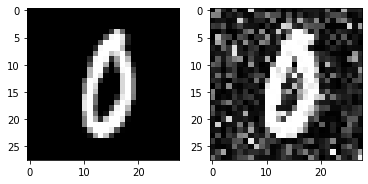

25  :  0.42084122973730365 25
50  :  0.691045861408748 25
75  :  0.38169481770872193 25
100  :  0.4797168108189919 25
125  :  0.4819489970033688 25
150  :  0.2482392765335038 25
175  :  0.07805299044502939 25
200  :  -0.08708961457739739 25
225  :  -0.08708961457739739 25
250  :  -0.08708961457739739 25
275  :  -0.08708961457739739 25
300  :  -0.08708961457739739 25
325  :  -0.08708961457739739 25
350  :  -0.08708961457739739 25
375  :  -0.08538292957009047 25
400  :  -0.08552239832548292 25
425  :  -0.08552239832548292 25
450  :  -0.08552239832548292 25
475  :  -0.08552239832548292 25
500  :  -0.08534249669320393 25
525  :  -0.08513876684431543 25
550  :  -0.08514329114746266 25
575  :  -0.08503722322900747 25
600  :  -0.08488442625067921 25
625  :  -0.08486459078306641 25
650  :  -0.08486474340106581 25
675  :  -0.08479460832072966 25
700  :  -0.08454943577832408 25
725  :  -0.08449398930237334 25
750  :  -0.08448438405079739 25
775  :  -0.08444118076102636 25
800  :  -0.084409147339

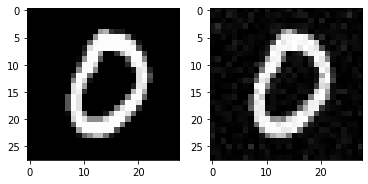

25  :  0.8857691851738818 25
50  :  0.8865266348727635 25
75  :  0.8883710979923883 25
100  :  0.8871749416458312 25
125  :  0.8871749416458312 25
150  :  0.8871749416458312 25
175  :  0.897774493968037 25
200  :  0.8965701409070197 25
225  :  0.8965701409070197 25
250  :  0.8965701409070197 25
275  :  0.8965701409070197 25
300  :  0.8965701409070197 25
325  :  0.8965701409070197 25
350  :  0.8965701409070197 25
375  :  0.9016465330530192 25
400  :  0.9010377553089239 25
425  :  0.9032577909083104 25
450  :  0.9032577909083104 25
475  :  0.9032577909083104 25
500  :  0.9047287546857379 25
525  :  0.9060451150362114 25
550  :  0.9060451150362114 25
575  :  0.9065963960339445 25
600  :  0.9073194406412456 25
625  :  0.908273391519063 25
650  :  0.9084067043614001 25
675  :  0.9085594184829545 25
700  :  0.9089716100661887 25
725  :  0.9089828504531083 25
750  :  0.9093848976798335 25
775  :  0.9093848976798335 25
800  :  0.9098491238129195 25
825  :  0.9100299252394606 25
850  :  0.91002

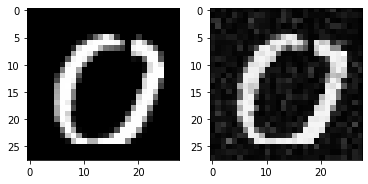

25  :  0.05106366816265523 25
50  :  0.6367286244193192 25
75  :  0.06065608919066362 25
100  :  0.18125686976349564 25
125  :  0.5004513315451413 25
150  :  0.309049003079563 25
175  :  0.41231819932312336 25
200  :  0.195158103878738 25
225  :  0.326084788645005 25
250  :  0.11698589031600776 25
275  :  0.021583434057759532 25
300  :  0.6744490352201156 25
325  :  0.6302174578721917 25
350  :  0.6987919946905419 25
375  :  0.7350464741197286 25
400  :  0.7548027328823315 25
425  :  0.757119073809672 25
450  :  0.757119073809672 25
475  :  0.757119073809672 25
500  :  0.7703671486322046 25
525  :  0.7644990326973358 25
550  :  0.7644990326973358 25
575  :  0.7644990326973358 25
600  :  0.7647908877075722 25
625  :  0.7644990326973358 25
650  :  0.7732776677289906 25
675  :  0.7730313613932077 25
700  :  0.7736978874211273 25
725  :  0.7737447072449928 25
750  :  0.7749553257201482 25
775  :  0.7789195213721134 25
800  :  0.7789010720525205 25
825  :  0.7789777567899252 25
850  :  0.78

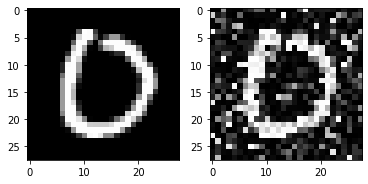

25  :  0.8889680602252081 25
50  :  0.8889680602252081 25
75  :  0.8875064234507497 25
100  :  0.89132912049922 25
125  :  0.8956779565417474 25
150  :  0.896711674874242 25
175  :  0.8960038583714058 25
200  :  0.8987716334477724 25
225  :  0.8980546947903401 25
250  :  0.8980546947903401 25
275  :  0.9014616220830078 25
300  :  0.9015291883347072 25
325  :  0.9015635417876345 25
350  :  0.9046247366465807 25
375  :  0.9045414259330606 25
400  :  0.9048597522859552 25
425  :  0.904689648792571 25
450  :  0.9059292207481487 25
475  :  0.9063021843439283 25
500  :  0.9063205080048806 25
525  :  0.9061765567008075 25
550  :  0.9063827403749891 25
575  :  0.9077123018080926 25
600  :  0.9092339431649719 25
625  :  0.9093499319850484 25
650  :  0.9095933005734576 25
675  :  0.9095618599974744 25
700  :  0.9101936748081274 25
725  :  0.9106610153634696 25
750  :  0.9106610153634696 25
775  :  0.9106610153634696 25
800  :  0.9106610153634696 25
Time:  83.6707227230072  seconds
Predicted clas

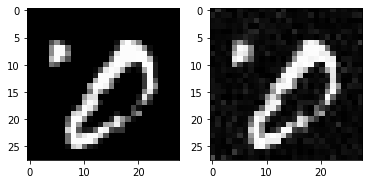

25  :  -0.20072821818509565 25
50  :  -0.13850499592172727 25
75  :  -0.09549371853189795 25
100  :  0.16743363210775272 25
125  :  0.5171180535180915 25
150  :  0.5452429984275622 25
175  :  0.5740919813303412 25
200  :  0.5854575807549759 25
225  :  0.5915436408185201 25
250  :  0.6056826670235509 25
275  :  0.619095173978465 25
300  :  0.6240911316628348 25
325  :  0.6241644261082121 25
350  :  0.6253459522638387 25
375  :  0.6341607555206001 25
400  :  0.6378206130782691 25
425  :  0.6443044375504244 25
450  :  0.6444168625502221 25
475  :  0.6445350865042414 25
500  :  0.644877990810121 25
525  :  0.6448815127478287 25
550  :  0.6451297938011582 25
575  :  0.6469934222693932 25
600  :  0.6469675386425598 25
625  :  0.6484490144474983 25
650  :  0.6498452393663898 25
675  :  0.6498452393663898 25
700  :  0.6498452393663898 25
725  :  0.6519730795538433 25
750  :  0.6529901302974116 25
775  :  0.6534997701493108 25
800  :  0.6539823471584706 25
825  :  0.6551744739461705 25
850  :  

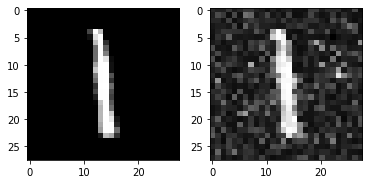

25  :  -0.28401279947780345 25
50  :  -0.2740829781704822 25
75  :  -0.11962324916794087 25
100  :  -0.1865797365661996 25
125  :  0.054978375276277025 25
150  :  0.39245806577188286 25
175  :  0.5032494547632004 25
200  :  0.5267153862897226 25
225  :  0.5377992885236438 25
250  :  0.5606941308201538 25
275  :  0.5820601720567913 25
300  :  0.6071695260767583 25
325  :  0.605603205852037 25
350  :  0.6098197934215062 25
375  :  0.6211584796201748 25
400  :  0.6212178579324189 25
425  :  0.625341966310538 25
450  :  0.6306757327142318 25
475  :  0.6353255973529516 25
500  :  0.6375288485043751 25
525  :  0.6375288485043751 25
550  :  0.6375288485043751 25
575  :  0.6377204476585774 25
600  :  0.6414772620246627 25
625  :  0.644153623297548 25
650  :  0.644153623297548 25
675  :  0.6445744841653306 25
700  :  0.6450825847964038 25
725  :  0.6455889456941699 25
750  :  0.6456445587215555 25
775  :  0.6468388991267318 25
800  :  0.6479620992201142 25
825  :  0.6487576394615477 25
850  :  

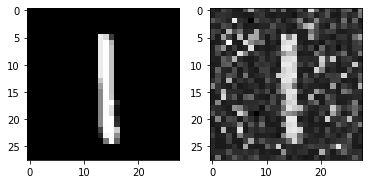

25  :  -0.2015929141857907 25
50  :  -0.042508402892260655 25
75  :  0.375989272567176 25
100  :  0.3374697375204665 25
125  :  0.56282627128517 25
150  :  0.5856302980980194 25
175  :  0.5952481681931798 25
200  :  0.6015986480844091 25
225  :  0.6030284131450485 25
250  :  0.6060733285870268 25
275  :  0.6078431693723572 25
300  :  0.6110619337505415 25
325  :  0.6110619337505415 25
350  :  0.6110619337505415 25
375  :  0.6152889287646807 25
400  :  0.6152889287646807 25
425  :  0.6152889287646807 25
450  :  0.616062774310421 25
475  :  0.6172058700340763 25
500  :  0.6179166272873606 25
525  :  0.6190172793092977 25
550  :  0.6197910714417039 25
575  :  0.6213947252193488 25
600  :  0.6223189927905957 25
625  :  0.6249180515331024 25
650  :  0.6249180515331024 25
675  :  0.6298875756458302 25
700  :  0.6298875756458302 25
725  :  0.6298875756458302 25
750  :  0.6298875756458302 25
775  :  0.6298875756458302 25
800  :  0.6311036792983722 25
825  :  0.6311036792983722 25
850  :  0.631

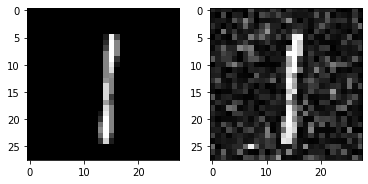

25  :  -0.2881981874062901 25
50  :  -0.28730204725411607 25
75  :  -0.28730204725411607 25
100  :  -0.28730204725411607 25
125  :  -0.28730204725411607 25
150  :  -0.28730204725411607 25
175  :  -0.28730204725411607 25
200  :  -0.2867131104985131 25
225  :  -0.2867131104985131 25
250  :  -0.2867131104985131 25
275  :  -0.286373224534352 25
300  :  -0.286373224534352 25
325  :  -0.2860674499049378 25
350  :  -0.2860674499049378 25
375  :  -0.2859202865505358 25
400  :  -0.28586665702834635 25
425  :  -0.2858207404595283 25
450  :  -0.2857686465233732 25
475  :  -0.28577111090517543 25
500  :  -0.2856047545109022 25
525  :  -0.2855323068456485 25
550  :  -0.2854032861462465 25
575  :  -0.2853615577592151 25
600  :  -0.2850853067211908 25
625  :  -0.28499371688056474 25
650  :  -0.28499871842957114 25
675  :  -0.2849124787836448 25
700  :  -0.2848833060347239 25
725  :  -0.2848932287583476 25
750  :  -0.28480454497367014 25
775  :  -0.2848193487671645 25
800  :  -0.28472833286459587 25
T

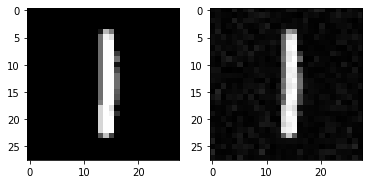

25  :  0.07915109767247347 25
50  :  0.1568908660163368 25
75  :  0.09460793235256162 25
100  :  0.44013910178492577 25
125  :  0.5166526792404695 25
150  :  0.544108071428538 25
175  :  0.5657770630035333 25
200  :  0.589255189921186 25
225  :  0.5970902987470925 25
250  :  0.6322172231188172 25
275  :  0.6411243207020082 25
300  :  0.649951823709458 25
325  :  0.6632265360171449 25
350  :  0.6633724889426313 25
375  :  0.6633724889426313 25
400  :  0.6650339881091087 25
425  :  0.6716719664459625 25
450  :  0.6775980344800292 25
475  :  0.6782339561394872 25
500  :  0.6788556586702975 25
525  :  0.6807946905446896 25
550  :  0.6812529974592337 25
575  :  0.6813375800328692 25
600  :  0.6837160892407655 25
625  :  0.6858631731166729 25
650  :  0.6895347617779584 25
675  :  0.6897888996471969 25
700  :  0.6906581285322032 25
725  :  0.6910074536325173 25
750  :  0.6910020800134643 25
775  :  0.6910020800134643 25
800  :  0.6922131671696131 25
825  :  0.6924284719411171 25
850  :  0.692

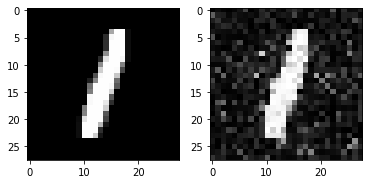

25  :  0.07326796373216277 25
50  :  0.5219295586974465 25
75  :  0.3844050349125545 25
100  :  0.5174532389404656 25
125  :  0.5759045094315673 25
150  :  0.5759045094315673 25
175  :  0.5920511297079061 25
200  :  0.5981213357630003 25
225  :  0.6065066613412764 25
250  :  0.6222429147447823 25
275  :  0.6222429147447823 25
300  :  0.6222429147447823 25
325  :  0.6232543567118688 25
350  :  0.6380515225247761 25
375  :  0.6382206351678015 25
400  :  0.6382206351678015 25
425  :  0.6513730175923798 25
450  :  0.6562886734659732 25
475  :  0.6563846477079858 25
500  :  0.6563846477079858 25
525  :  0.6591278225002266 25
550  :  0.6612251978325144 25
575  :  0.6660516951263784 25
600  :  0.6660516951263784 25
625  :  0.667018394479048 25
650  :  0.667018394479048 25
675  :  0.6682675478912978 25
700  :  0.6687813834462997 25
725  :  0.6714364861261919 25
750  :  0.6717249455203458 25
775  :  0.6729758030712039 25
800  :  0.6753451674350177 25
825  :  0.6753451674350177 25
850  :  0.6762

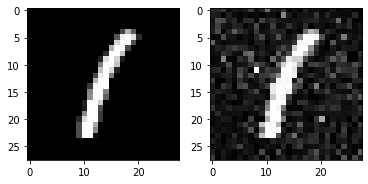

25  :  0.45687574544113274 25
50  :  0.49077771206555293 25
75  :  0.5211053949129709 25
100  :  0.5363817235739707 25
125  :  0.5659711000298131 25
150  :  0.5566278806240001 25
175  :  0.5680505610676541 25
200  :  0.6159843667083685 25
225  :  0.613248668610921 25
250  :  0.6430374194978548 25
275  :  0.6404746554026057 25
300  :  0.6514532887682789 25
325  :  0.6539854577284104 25
350  :  0.6565105615929099 25
375  :  0.6586683338303962 25
400  :  0.6585713515229474 25
425  :  0.6578595156765721 25
450  :  0.6578595156765721 25
475  :  0.6667949594436517 25
500  :  0.663620216902405 25
525  :  0.663620216902405 25
550  :  0.6684130230552233 25
575  :  0.6689439059311933 25
600  :  0.672987522109799 25
625  :  0.6729814071835525 25
650  :  0.6746237476836686 25
675  :  0.6738523388730241 25
700  :  0.6755829699883495 25
725  :  0.6762325899165336 25
750  :  0.6788472022029655 25
775  :  0.6793182689176274 25
800  :  0.6800052838877447 25
825  :  0.6812915401854298 25
850  :  0.68151

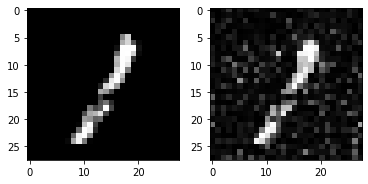

25  :  0.4760130047574383 25
50  :  0.6066747485015598 25
75  :  0.6043319303297512 25
100  :  0.5937612099563211 25
125  :  0.6205793031591852 25
150  :  0.6318664444251471 25
175  :  0.6414679100333928 25
200  :  0.6421440222026186 25
225  :  0.6437491547430301 25
250  :  0.6471974689723096 25
275  :  0.647693280869033 25
300  :  0.6475084712454068 25
325  :  0.6491089829270018 25
350  :  0.648737453272439 25
375  :  0.648737453272439 25
400  :  0.6511950971106836 25
425  :  0.6508454623850162 25
450  :  0.6510392811462457 25
475  :  0.6517926572599988 25
500  :  0.653437536891477 25
525  :  0.6537758228888473 25
550  :  0.656101093031855 25
575  :  0.656101093031855 25
600  :  0.6564921029233987 25
625  :  0.6566690441828945 25
650  :  0.6582020602555103 25
675  :  0.6581585328613744 25
700  :  0.6581585328613744 25
725  :  0.6587920995894535 25
750  :  0.6587547263601141 25
775  :  0.6587547263601141 25
800  :  0.6591477793246688 25
825  :  0.659818457849923 25
850  :  0.6598557469

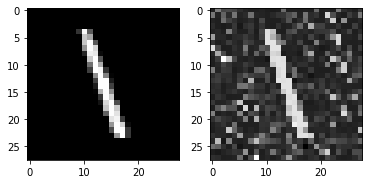

25  :  -0.2285437224543605 25
50  :  -0.02369891391051082 25
75  :  0.357242972052264 25
100  :  0.444423286061689 25
125  :  0.5311717788998276 25
150  :  0.5729328305375199 25
175  :  0.5964051060523429 25
200  :  0.6104528059476702 25
225  :  0.6213244432164774 25
250  :  0.6283479370491142 25
275  :  0.6283479370491142 25
300  :  0.629083158407379 25
325  :  0.6291641581114501 25
350  :  0.633004075120916 25
375  :  0.6429518124733302 25
400  :  0.6474320809046479 25
425  :  0.6485847277556729 25
450  :  0.6500935856821883 25
475  :  0.6505365906555636 25
500  :  0.6524816011742023 25
525  :  0.6532466520319758 25
550  :  0.6537664604480666 25
575  :  0.656505154614676 25
600  :  0.6569593509927782 25
625  :  0.6569593509927782 25
650  :  0.6586004707108594 25
675  :  0.6599187716789133 25
700  :  0.6599166368606226 25
725  :  0.6599166368606226 25
750  :  0.6599166368606226 25
775  :  0.6599166368606226 25
800  :  0.6599166368606226 25
825  :  0.6604541673740876 25
850  :  0.66045

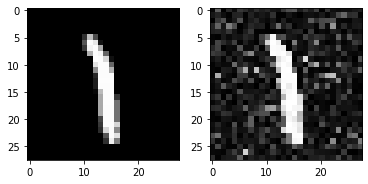

25  :  -0.2907978218162604 25
50  :  -0.2907978218162604 25
75  :  -0.2907978218162604 25
100  :  -0.259134400020734 25
125  :  0.02116552782109335 25
150  :  0.4228551416163298 25
175  :  0.49847428817979766 25
200  :  0.516654623407617 25
225  :  0.5441350318677182 25
250  :  0.5441350318677182 25
275  :  0.5441350318677182 25
300  :  0.5441350318677182 25
325  :  0.5524375181172123 25
350  :  0.5622880302459533 25
375  :  0.5895225674063316 25
400  :  0.5933066816478643 25
425  :  0.5934075344999509 25
450  :  0.5961357682735788 25
475  :  0.5976558675200679 25
500  :  0.6030558289832197 25
525  :  0.6106849450420939 25
550  :  0.6126641958492046 25
575  :  0.615709727704544 25
600  :  0.618609874720052 25
625  :  0.6214590274935758 25
650  :  0.6251294793019965 25
675  :  0.6277852802857469 25
700  :  0.6301231939043263 25
725  :  0.6366660188076505 25
750  :  0.6375574045417406 25
775  :  0.6389854705424062 25
800  :  0.6389498257281536 25
825  :  0.6393545002475457 25
850  :  0.6

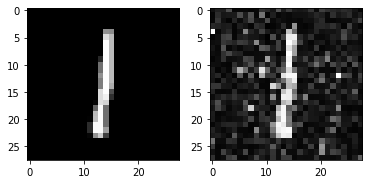

25  :  -0.2618212332828106 25
50  :  -0.2618212332828106 25
75  :  -0.24196337266981452 25
100  :  -0.23277372723397036 25
125  :  -0.20850748425852625 25
150  :  -0.020904614164928365 25
175  :  0.20818695285250635 25
200  :  0.46140859545106905 25
225  :  0.519945191157309 25
250  :  0.5239732385494873 25
275  :  0.5681087164373894 25
300  :  0.6048191016476616 25
325  :  0.5995180068259606 25
350  :  0.6271858637386818 25
375  :  0.6344850044732491 25
400  :  0.6382122964249823 25
425  :  0.6515022535921682 25
450  :  0.6515022535921682 25
475  :  0.6515022535921682 25
500  :  0.6527948718712457 25
525  :  0.6535030481996699 25
550  :  0.6546156391194795 25
575  :  0.6574518832384728 25
600  :  0.6593230902145655 25
625  :  0.6593435272459262 25
650  :  0.6600553173674638 25
675  :  0.6598102784175961 25
700  :  0.661734898530507 25
725  :  0.661734898530507 25
750  :  0.6628167501215555 25
775  :  0.6633794700215305 25
800  :  0.6658334176538613 25
825  :  0.6657961988050628 25
850

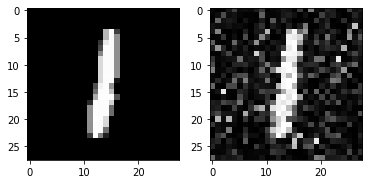

25  :  -0.28137095118168076 25
50  :  -0.22830733543369316 25
75  :  -0.08379521959899747 25
100  :  0.21067619638415672 25
125  :  0.39888295268595164 25
150  :  0.4416804676842835 25
175  :  0.4629156183866653 25
200  :  0.5012458130978534 25
225  :  0.5195532661772038 25
250  :  0.5561961583680081 25
275  :  0.5713129271357922 25
300  :  0.5512974702022406 25
325  :  0.5764349553112176 25
350  :  0.5784604474832159 25
375  :  0.5784604474832159 25
400  :  0.5784604474832159 25
425  :  0.5784604474832159 25
450  :  0.5784604474832159 25
475  :  0.5877920377378658 25
500  :  0.5877920377378658 25
525  :  0.6009809911564348 25
550  :  0.601026719497856 25
575  :  0.601026719497856 25
600  :  0.6086823982632633 25
625  :  0.6114317806999134 25
650  :  0.6122210808539064 25
675  :  0.6122210808539064 25
700  :  0.6171465316220541 25
725  :  0.6184038928778643 25
750  :  0.6186289234795126 25
775  :  0.6200514538553142 25
800  :  0.6206687713068524 25
825  :  0.6207774526588535 25
850  : 

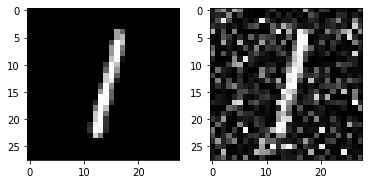

25  :  -0.260422905236455 25
50  :  -0.25679855562671755 25
75  :  -0.21471857261897784 25
100  :  -0.07703066688802138 25
125  :  0.24296202222192909 25
150  :  0.5697374217218153 25
175  :  0.5789543372667608 25
200  :  0.5789543372667608 25
225  :  0.6038754413470732 25
250  :  0.6008521736472201 25
275  :  0.6008521736472201 25
300  :  0.6043190938463403 25
325  :  0.6043190938463403 25
350  :  0.6043190938463403 25
375  :  0.6160411483568526 25
400  :  0.629130661101881 25
425  :  0.62973727177697 25
450  :  0.6398910367808801 25
475  :  0.6441718437718769 25
500  :  0.6451015160553922 25
525  :  0.6499720867354417 25
550  :  0.6546525705825142 25
575  :  0.6547762938361714 25
600  :  0.6551079946321718 25
625  :  0.655568002713067 25
650  :  0.6561702906685508 25
675  :  0.6606027182648626 25
700  :  0.6606392608162837 25
725  :  0.6615093644991257 25
750  :  0.662967800671119 25
775  :  0.6630959993040701 25
800  :  0.6641952393866696 25
825  :  0.6642964310125632 25
850  :  0.6

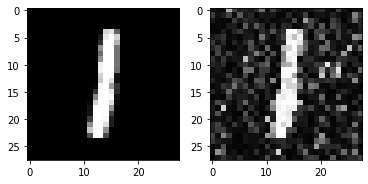

25  :  -0.033799655390154254 25
50  :  -0.001600257130028565 25
75  :  0.109607378958271 25
100  :  0.3406216458912447 25
125  :  0.37077823288205247 25
150  :  0.5345838130485547 25
175  :  0.5375946028139957 25
200  :  0.5645282441389214 25
225  :  0.5907295187267505 25
250  :  0.6142279586941813 25
275  :  0.6275645761594393 25
300  :  0.6291895839253616 25
325  :  0.6371502558602818 25
350  :  0.6517025164624015 25
375  :  0.6558764199893266 25
400  :  0.6615796551404577 25
425  :  0.6613805158758013 25
450  :  0.6613805158758013 25
475  :  0.6635769804463849 25
500  :  0.6638049582598692 25
525  :  0.6638049582598692 25
550  :  0.6649269840996517 25
575  :  0.6659188037142164 25
600  :  0.66806643759701 25
625  :  0.6685687246027205 25
650  :  0.6698025431437369 25
675  :  0.6697300686325482 25
700  :  0.6697300686325482 25
725  :  0.6711288637949404 25
750  :  0.6726595266788655 25
775  :  0.6731060130204571 25
800  :  0.6735773058783586 25
825  :  0.6738710692676158 25
850  :  0

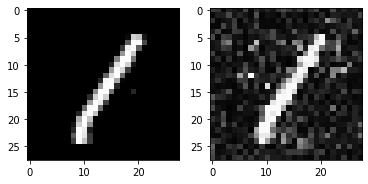

25  :  -0.23120869372737024 25
50  :  -0.22933937696354612 25
75  :  -0.21952964929523996 25
100  :  -0.21082984371963281 25
125  :  -0.1835121176936975 25
150  :  -0.06522778391668502 25
175  :  0.2748150365403562 25
200  :  0.5607669057939684 25
225  :  0.5800780853389171 25
250  :  0.6168042926725454 25
275  :  0.6264122446868204 25
300  :  0.6270581572792546 25
325  :  0.6296728619742141 25
350  :  0.6323146580858457 25
375  :  0.6456261147441218 25
400  :  0.6478905908143229 25
425  :  0.6555986537288206 25
450  :  0.6575120850263172 25
475  :  0.6630059920379284 25
500  :  0.6747047808920479 25
525  :  0.6748423628332842 25
550  :  0.6786469450585508 25
575  :  0.6798968186951508 25
600  :  0.6808422446801882 25
625  :  0.6827750423379724 25
650  :  0.6834708613780331 25
675  :  0.6850993379198652 25
700  :  0.6861479119469851 25
725  :  0.6861678183635979 25
750  :  0.6867173875103791 25
775  :  0.6867173875103791 25
800  :  0.6873337549789789 25
825  :  0.6875443278770654 25
85

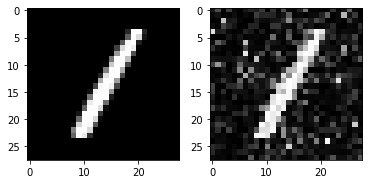

25  :  -0.06756693495953514 25
50  :  -0.06756693495953514 25
75  :  -0.06751176827091326 25
100  :  -0.06672075489151308 25
125  :  -0.06669875170051281 25
150  :  -0.06595212385120175 25
175  :  -0.06595212385120175 25
200  :  -0.06595212385120175 25
225  :  -0.06560882989201794 25
250  :  -0.06558648777859688 25
275  :  -0.06563121126173732 25
300  :  -0.06497195289152546 25
325  :  -0.06499487210399207 25
350  :  -0.06503097903166732 25
375  :  -0.06504893871120127 25
400  :  -0.06504893871120127 25
425  :  -0.06504893871120127 25
450  :  -0.06474224520938049 25
475  :  -0.06472590765959946 25
500  :  -0.06474688659556199 25
525  :  -0.06471415947322928 25
550  :  -0.06457765400159204 25
575  :  -0.0644533762469468 25
600  :  -0.06430937075872079 25
625  :  -0.06430565693428103 25
650  :  -0.06416991524228205 25
675  :  -0.06415268793499662 25
700  :  -0.06402838871887129 25
725  :  -0.06400798174225159 25
750  :  -0.06399315186667631 25
775  :  -0.06387143863301714 25
800  :  -0.0

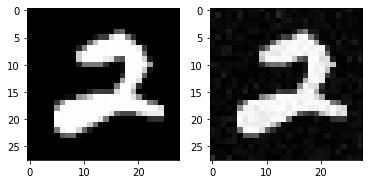

25  :  -0.07629426053339822 25
50  :  -0.07233731782659564 25
75  :  -0.07221898040971847 25
100  :  -0.0734657533407691 25
125  :  -0.05994754104106581 25
150  :  -0.05544404700478256 25
175  :  -0.048039383929066426 25
200  :  0.09556127634225103 25
225  :  0.39569521862333856 25
250  :  0.577679069239939 25
275  :  0.5839905771881553 25
300  :  0.6275963995265501 25
325  :  0.6602236849310028 25
350  :  0.6632606775623554 25
375  :  0.6736930792840586 25
400  :  0.6845503703525178 25
425  :  0.7003530278162761 25
450  :  0.7003530278162761 25
475  :  0.7058273241142634 25
500  :  0.7135697668863087 25
525  :  0.7135697668863087 25
550  :  0.7147529063660567 25
575  :  0.7168806282358964 25
600  :  0.7217070640768057 25
625  :  0.7194065656203298 25
650  :  0.7262090322439154 25
675  :  0.727369160499248 25
700  :  0.7322172056155714 25
725  :  0.7361145102982849 25
750  :  0.7369361822711283 25
775  :  0.7383576390114184 25
800  :  0.7395040643752185 25
825  :  0.7401038261083971 25

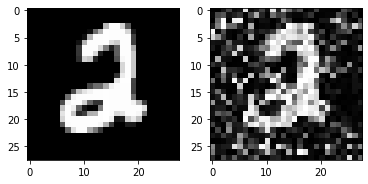

25  :  0.13586419880707584 25
50  :  0.13586419880707584 25
75  :  0.1244268949186253 25
100  :  0.1450456859731893 25
125  :  0.14688048904304257 25
150  :  0.24955883055737382 25
175  :  0.32853612490686585 25
200  :  0.2731392877133062 25
225  :  0.3787024289793538 25
250  :  0.41824667958086714 25
275  :  0.40122026131290134 25
300  :  0.4032820573294701 25
325  :  0.46997837764056205 25
350  :  0.5041140882223665 25
375  :  0.5083611350889291 25
400  :  0.4951375395505675 25
425  :  0.563726268562486 25
450  :  0.527169422290815 25
475  :  0.5633185397696597 25
500  :  0.5868772151110676 25
525  :  0.6250408106328864 25
550  :  0.6759104830222418 25
575  :  0.6723731585029024 25
600  :  0.7045713024847353 25
625  :  0.7051134674646399 25
650  :  0.7165158489441208 25
675  :  0.7285102232895024 25
700  :  0.7365464969006914 25
725  :  0.7361081260317256 25
750  :  0.7461032182101455 25
775  :  0.7395510707436239 25
800  :  0.748106375865602 25
825  :  0.748106375865602 25
850  :  0

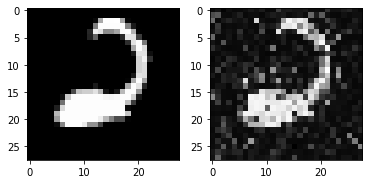

25  :  -0.09336820130427653 25
50  :  -0.09336820130427653 25
75  :  -0.09336820130427653 25
100  :  -0.08268804586063633 25
125  :  -0.08460757288438486 25
150  :  -0.0700603316276292 25
175  :  -0.04228448134093876 25
200  :  0.014381139950223276 25
225  :  0.1956403144290565 25
250  :  0.40251085087097416 25
275  :  0.5761653548314528 25
300  :  0.5880375358676032 25
325  :  0.5984313388415501 25
350  :  0.6482344049596408 25
375  :  0.665968377068266 25
400  :  0.665968377068266 25
425  :  0.665968377068266 25
450  :  0.665968377068266 25
475  :  0.665968377068266 25
500  :  0.6691210903787715 25
525  :  0.6740459361211987 25
550  :  0.6830633464749192 25
575  :  0.6921236473971777 25
600  :  0.6943556265198686 25
625  :  0.7023600533103507 25
650  :  0.7157009913265545 25
675  :  0.7169958884193581 25
700  :  0.7169958884193581 25
725  :  0.7169958884193581 25
750  :  0.7169958884193581 25
775  :  0.7191970072143429 25
800  :  0.718978306796323 25
825  :  0.7218980733062794 25
850

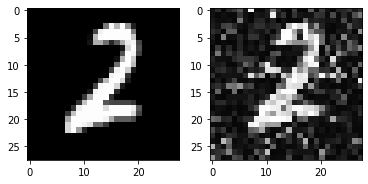

25  :  0.667848769974263 25
50  :  0.682133740991109 25
75  :  0.6888004353129114 25
100  :  0.6685044751784879 25
125  :  0.6823270680009766 25
150  :  0.667349311083524 25
175  :  0.7146039098633985 25
200  :  0.7206513452076548 25
225  :  0.7551731239184525 25
250  :  0.7442573532960075 25
275  :  0.7520145059763892 25
300  :  0.7442573532960075 25
325  :  0.7536172953862668 25
350  :  0.7514089380193629 25
375  :  0.7551727813330862 25
400  :  0.7530180342232783 25
425  :  0.7545630554680179 25
450  :  0.7615006084046371 25
475  :  0.7630619292375378 25
500  :  0.7630619292375378 25
525  :  0.7630619292375378 25
550  :  0.7630619292375378 25
575  :  0.7633121270016514 25
600  :  0.7661376465395213 25
625  :  0.7693288882196972 25
650  :  0.7693763810524463 25
675  :  0.7708892860421774 25
700  :  0.7712399614169688 25
725  :  0.7715844110466871 25
750  :  0.7750601754599487 25
775  :  0.7748838129396887 25
800  :  0.7775419161056971 25
825  :  0.77766763874898 25
850  :  0.77805346

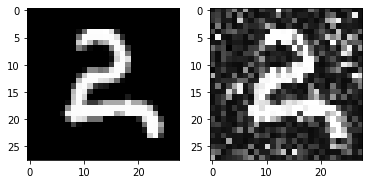

25  :  0.3136982157324583 25
50  :  0.40900171947875397 25
75  :  0.3939668718247798 25
100  :  0.45042959301966445 25
125  :  0.5093141730933235 25
150  :  0.5478846891016282 25
175  :  0.6488657181392019 25
200  :  0.7070444762750794 25
225  :  0.7165364601270232 25
250  :  0.7309884239292915 25
275  :  0.7520726507359847 25
300  :  0.7583486448724939 25
325  :  0.7660166451529642 25
350  :  0.7745194106910234 25
375  :  0.7744992205558137 25
400  :  0.7796731399315494 25
425  :  0.7793858673134223 25
450  :  0.7811752052887762 25
475  :  0.7876880072719332 25
500  :  0.786991569375088 25
525  :  0.7909724427115412 25
550  :  0.7909724427115412 25
575  :  0.7909724427115412 25
600  :  0.7909724427115412 25
625  :  0.7925474515159165 25
650  :  0.7925474515159165 25
675  :  0.7956032943350563 25
700  :  0.7963814604024068 25
725  :  0.7957096611809331 25
750  :  0.7974055482613283 25
775  :  0.7973299902762234 25
800  :  0.798040411681871 25
825  :  0.7982416803012398 25
850  :  0.798

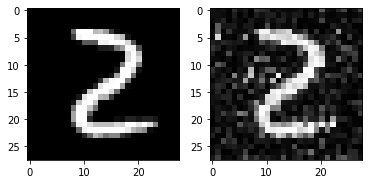

25  :  -0.01361645528436417 25
50  :  0.14419382375600123 25
75  :  0.03875778401301161 25
100  :  0.13182417251758322 25
125  :  0.260588608834974 25
150  :  0.48779207290274224 25
175  :  0.6723292549087825 25
200  :  0.7078784309747979 25
225  :  0.7214060343142876 25
250  :  0.719509913772288 25
275  :  0.7422667625403822 25
300  :  0.7423605158468369 25
325  :  0.7614867999271087 25
350  :  0.7631485984125653 25
375  :  0.7631485984125653 25
400  :  0.7691954187351953 25
425  :  0.769131936821033 25
450  :  0.7758669341012506 25
475  :  0.77676217920991 25
500  :  0.7765022938864041 25
525  :  0.7834369813215261 25
550  :  0.7834369813215261 25
575  :  0.7834369813215261 25
600  :  0.7834369813215261 25
625  :  0.7834369813215261 25
650  :  0.7846437292959526 25
675  :  0.78464446973597 25
700  :  0.7846437292959526 25
725  :  0.7858886102897473 25
750  :  0.7865918400845647 25
775  :  0.7868497396217351 25
800  :  0.7874194887241585 25
825  :  0.7897702310948171 25
850  :  0.7901

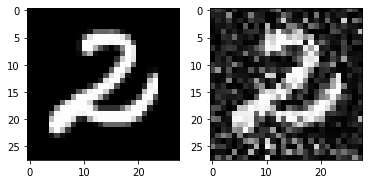

25  :  0.15868486219566358 25
50  :  0.30496568001551255 25
75  :  0.1676680807801846 25
100  :  0.24368277366891972 25
125  :  0.2015314243549588 25
150  :  0.393766678522139 25
175  :  0.5175146286160566 25
200  :  0.6125706991508937 25
225  :  0.6592579380346565 25
250  :  0.5574989928304626 25
275  :  0.6460576341202914 25
300  :  0.6019329057673428 25
325  :  0.6169128758592727 25
350  :  0.6033838423747332 25
375  :  0.6309589534518995 25
400  :  0.6616796863747272 25
425  :  0.6610044015110574 25
450  :  0.672071635676204 25
475  :  0.6954295525999146 25
500  :  0.6954645759734495 25
525  :  0.6954645759734495 25
550  :  0.6991054789500151 25
575  :  0.7085976459660681 25
600  :  0.7133812397526191 25
625  :  0.7133812397526191 25
650  :  0.7145140108879695 25
675  :  0.7189774922646667 25
700  :  0.7197486552155583 25
725  :  0.7197486552155583 25
750  :  0.7197486552155583 25
775  :  0.7197486552155583 25
800  :  0.7211509319367313 25
825  :  0.7259802699793767 25
850  :  0.72

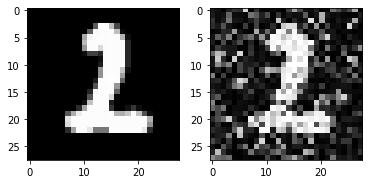

25  :  -0.13669500270655588 25
50  :  -0.13574277082048192 25
75  :  -0.13503643470586568 25
100  :  -0.13416364788777185 25
125  :  -0.13445833668340923 25
150  :  -0.13445833668340923 25
175  :  -0.13442767512260495 25
200  :  -0.13445833668340923 25
225  :  -0.1311629938760761 25
250  :  -0.12550051526947537 25
275  :  -0.1139927350439971 25
300  :  -0.11712513870771563 25
325  :  -0.0900357357579134 25
350  :  -0.08052079275566443 25
375  :  -0.08129793597596802 25
400  :  0.06763054152972603 25
425  :  0.5232297996955757 25
450  :  0.5596268200289662 25
475  :  0.6457705835956205 25
500  :  0.6562862531625799 25
525  :  0.6663953910570801 25
550  :  0.6670218177920323 25
575  :  0.6802547841231865 25
600  :  0.6918899581936342 25
625  :  0.6899886216610495 25
650  :  0.6899886216610495 25
675  :  0.700563580764156 25
700  :  0.7053692253750711 25
725  :  0.7038929834400424 25
750  :  0.7084417182677507 25
775  :  0.7126202707034617 25
800  :  0.7121145022635367 25
825  :  0.717434

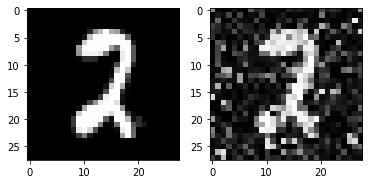

25  :  -0.07802754281553209 25
50  :  -0.07525245357779686 25
75  :  -0.04799199023291023 25
100  :  0.05452518613666113 25
125  :  -0.01242219123491256 25
150  :  0.0025834089384459413 25
175  :  0.17484698196867815 25
200  :  0.07921286361800212 25
225  :  0.20329629646708236 25
250  :  0.23660311761211023 25
275  :  0.5292153959074384 25
300  :  0.6365591680148551 25
325  :  0.6309063754768874 25
350  :  0.6959405884215413 25
375  :  0.6973619527647832 25
400  :  0.6973619527647832 25
425  :  0.7031254212209319 25
450  :  0.7070770137633345 25
475  :  0.7098188956963267 25
500  :  0.7098188956963267 25
525  :  0.7122572015414541 25
550  :  0.7160648506473644 25
575  :  0.7209066148655965 25
600  :  0.7264129906776178 25
625  :  0.7342741376810659 25
650  :  0.7342741376810659 25
675  :  0.7342741376810659 25
700  :  0.7345634699322042 25
725  :  0.7380865180912772 25
750  :  0.7380865180912772 25
775  :  0.7380865180912772 25
800  :  0.7385144178832099 25
825  :  0.7399761642782169 

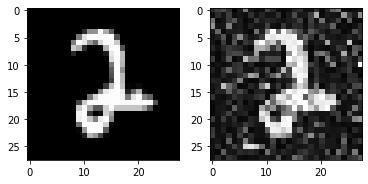

25  :  -0.09990298732588687 25
50  :  -0.09846293171048437 25
75  :  -0.0968420492223796 25
100  :  -0.08007717023599281 25
125  :  -0.09802485471460781 25
150  :  -0.09661303046618908 25
175  :  -0.09584228151404461 25
200  :  -0.08719635048793878 25
225  :  -0.03654819983101726 25
250  :  0.03732962999019346 25
275  :  0.07212645129390571 25
300  :  0.3677980853560647 25
325  :  0.6402600839292435 25
350  :  0.6325820956779302 25
375  :  0.623084946791151 25
400  :  0.6388446829159158 25
425  :  0.6512266421201715 25
450  :  0.6529100319504695 25
475  :  0.6611356517686016 25
500  :  0.665707791756592 25
525  :  0.6770392573993886 25
550  :  0.6761954491514108 25
575  :  0.6748949967609676 25
600  :  0.6798017100900193 25
625  :  0.6783229802926273 25
650  :  0.6781844700826847 25
675  :  0.6802138729029223 25
700  :  0.6802125546543374 25
725  :  0.6803635381092739 25
750  :  0.6833439452367409 25
775  :  0.6830201702951532 25
800  :  0.6849190084441816 25
825  :  0.6848339875777969

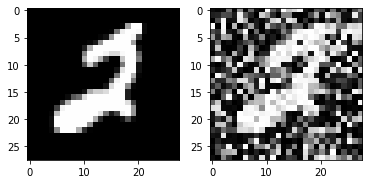

25  :  0.6283817805440448 25
50  :  0.6283817805440448 25
75  :  0.5598531619976599 25
100  :  0.6200441061184986 25
125  :  0.6445052427433129 25
150  :  0.6392910745878506 25
175  :  0.7184641403616178 25
200  :  0.7488325674962177 25
225  :  0.7406367815213271 25
250  :  0.7343549539074692 25
275  :  0.7506814372813295 25
300  :  0.7651911672270731 25
325  :  0.7617873911573341 25
350  :  0.7581842079939667 25
375  :  0.7665525088940972 25
400  :  0.7733470450110351 25
425  :  0.7733470450110351 25
450  :  0.7758503380531608 25
475  :  0.7762771555017112 25
500  :  0.7813451933113105 25
525  :  0.7902507358619651 25
550  :  0.7926353197866547 25
575  :  0.7924318069567777 25
600  :  0.7937995161502858 25
625  :  0.7946631789310186 25
650  :  0.793725234729691 25
675  :  0.7962124805517724 25
700  :  0.7962124805517724 25
725  :  0.79941082009422 25
750  :  0.8041830426685341 25
775  :  0.8041830426685341 25
800  :  0.8041830426685341 25
825  :  0.8041830426685341 25
850  :  0.804447

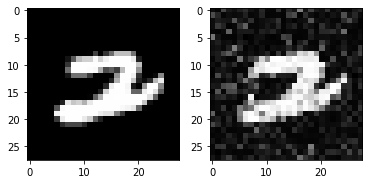

25  :  0.3132918572409524 25
50  :  0.6475255720742521 25
75  :  0.6222077102968238 25
100  :  0.5961446787531256 25
125  :  0.6194914339452118 25
150  :  0.6094890138106134 25
175  :  0.6580898876516742 25
200  :  0.6395316128781405 25
225  :  0.6346830325174009 25
250  :  0.6644912556479136 25
275  :  0.6524899075595711 25
300  :  0.6546961200207977 25
325  :  0.6686036597189958 25
350  :  0.6671500718064778 25
375  :  0.6830624435781859 25
400  :  0.7040769874039393 25
425  :  0.69767045363368 25
450  :  0.6979619458358521 25
475  :  0.6960548536999929 25
500  :  0.7018000037985149 25
525  :  0.7040634495524798 25
550  :  0.7245999228457392 25
575  :  0.7104807149303172 25
600  :  0.7104807149303172 25
625  :  0.7104807149303172 25
650  :  0.7125413662247062 25
675  :  0.7114266682250302 25
700  :  0.7148981674722985 25
725  :  0.7150387806558277 25
750  :  0.7180900654159054 25
775  :  0.7180900654159054 25
800  :  0.7180900654159054 25
825  :  0.7182356914616012 25
850  :  0.71898

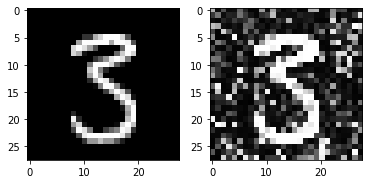

25  :  0.07668861837933744 25
50  :  0.43348907237238055 25
75  :  0.093441336682482 25
100  :  -0.09166379102667671 25
125  :  -0.09166379102667671 25
150  :  -0.09156889771604365 25
175  :  -0.09166379102667671 25
200  :  -0.09166379102667671 25
225  :  -0.09166379102667671 25
250  :  -0.09139107467927865 25
275  :  -0.09073531440638938 25
300  :  -0.09013640180650212 25
325  :  -0.09059998694079857 25
350  :  -0.08927890269554456 25
375  :  -0.09018511740185209 25
400  :  -0.09018511740185209 25
425  :  -0.08975492910412519 25
450  :  -0.08934068277549734 25
475  :  -0.08874889629086319 25
500  :  -0.08879267528274987 25
525  :  -0.08879267528274987 25
550  :  -0.0887329141074722 25
575  :  -0.08851991834302475 25
600  :  -0.08845594876443935 25
625  :  -0.0884683593289472 25
650  :  -0.0883888776611475 25
675  :  -0.08830209499295738 25
700  :  -0.08831987618733111 25
725  :  -0.08831987618733111 25
750  :  -0.08820455599505705 25
775  :  -0.08801505802632426 25
800  :  -0.08788043

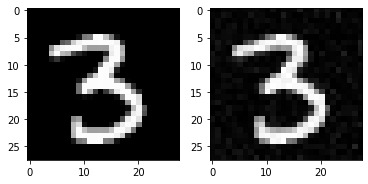

25  :  0.03591290355092247 25
50  :  0.5525380964832847 25
75  :  -0.07533483106325972 25
100  :  -0.07540582398411594 25
125  :  -0.04573941510801621 25
150  :  0.05032948993234665 25
175  :  -0.0749357906609126 25
200  :  -0.0749357906609126 25
225  :  -0.07454297384645087 25
250  :  -0.07470522030113363 25
275  :  -0.07331729585114782 25
300  :  -0.07331729585114782 25
325  :  -0.07331729585114782 25
350  :  -0.07331729585114782 25
375  :  -0.07316605899773104 25
400  :  -0.07335570399090147 25
425  :  -0.07187372173762929 25
450  :  -0.07201114975211242 25
475  :  -0.07201114975211242 25
500  :  -0.07201114975211242 25
525  :  -0.07201114975211242 25
550  :  -0.07159548751658035 25
575  :  -0.07118926778200924 25
600  :  -0.07049210331036537 25
625  :  -0.070100188152458 25
650  :  -0.0701769344300402 25
675  :  -0.07017234300691289 25
700  :  -0.07024649008148481 25
725  :  -0.07014727167252444 25
750  :  -0.06984627312317931 25
775  :  -0.06991088399064832 25
800  :  -0.069621203

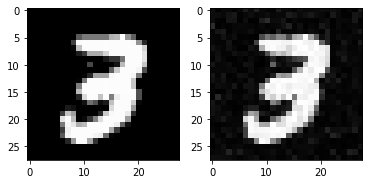

25  :  0.13662343809283356 25
50  :  0.6394765626162957 25
75  :  0.48805994380635026 25
100  :  0.36002051107080457 25
125  :  0.4807981737555891 25
150  :  0.16722791856174346 25
175  :  -0.11091131346330002 25
200  :  -0.11093541096939247 25
225  :  0.15359681129587716 25
250  :  0.1948166420660165 25
275  :  0.1580335094207974 25
300  :  -0.11099840731848526 25
325  :  0.22321386545427152 25
350  :  -0.11099840731848526 25
375  :  -0.11099840731848526 25
400  :  -0.10893996261038896 25
425  :  -0.10855322062754025 25
450  :  -0.10155875180321405 25
475  :  -0.0932930698252219 25
500  :  -0.08586764457828633 25
525  :  -0.05178689790815055 25
550  :  0.30853723261151167 25
575  :  0.6286641915751927 25
600  :  0.6787857827308885 25
625  :  0.6799751855897214 25
650  :  0.6799543053557142 25
675  :  0.6823381191290505 25
700  :  0.6926505317770746 25
725  :  0.6963556250770437 25
750  :  0.7049250730129625 25
775  :  0.7028736463508429 25
800  :  0.710535338977313 25
825  :  0.714625

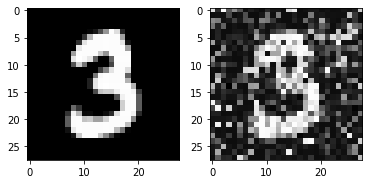

25  :  0.14542435985820473 25
50  :  0.6540648486685927 25
75  :  0.3687595582522387 25
100  :  0.3937169336043125 25
125  :  0.5411470559949246 25
150  :  0.48790711604522363 25
175  :  0.4154245134099184 25
200  :  -0.11328952525236863 25
225  :  -0.10058181691230006 25
250  :  -0.11273807895324478 25
275  :  -0.11132564658760014 25
300  :  0.22385064991066667 25
325  :  -0.10584319823000865 25
350  :  0.07292074025535589 25
375  :  0.0845187930036349 25
400  :  0.4008403191132739 25
425  :  0.462227534846791 25
450  :  0.5720826319094467 25
475  :  0.6430260847153542 25
500  :  0.6410365608735856 25
525  :  0.6261132701605677 25
550  :  0.6414577181829288 25
575  :  0.6744266176308599 25
600  :  0.6733864367373786 25
625  :  0.698056128593337 25
650  :  0.6957834444940872 25
675  :  0.7182062466761753 25
700  :  0.7107378311440391 25
725  :  0.7174433107123079 25
750  :  0.7174433107123079 25
775  :  0.7233585618738807 25
800  :  0.7233585618738807 25
825  :  0.7281127698074366 25
8

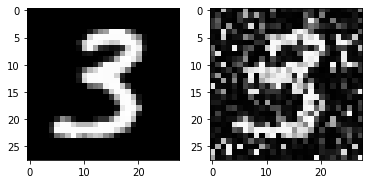

25  :  -0.020503886446706004 25
50  :  0.5766003331034594 25
75  :  0.2773553889489988 25
100  :  0.12443459821976172 25
125  :  -0.10970568684413859 25
150  :  -0.14323765459918797 25
175  :  -0.14323765459918797 25
200  :  -0.14323765459918797 25
225  :  -0.141381623320529 25
250  :  -0.1416324990366814 25
275  :  -0.1416324990366814 25
300  :  -0.1416324990366814 25
325  :  -0.1416324990366814 25
350  :  -0.1416324990366814 25
375  :  -0.1416324990366814 25
400  :  -0.1416324990366814 25
425  :  -0.1416324990366814 25
450  :  -0.1416324990366814 25
475  :  -0.1416324990366814 25
500  :  -0.1416324990366814 25
525  :  -0.1416324990366814 25
550  :  -0.1416324990366814 25
575  :  -0.1416324990366814 25
600  :  -0.1416324990366814 25
625  :  -0.1416324990366814 25
650  :  -0.1415302372429219 25
675  :  -0.1415302372429219 25
700  :  -0.14069364789964472 25
725  :  -0.13952684400637683 25
750  :  -0.14069364789964472 25
775  :  -0.14025400888290035 25
800  :  -0.14025400888290035 25
825

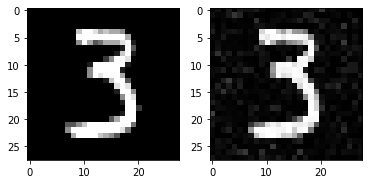

25  :  -0.09681421892434816 25
50  :  -0.0953300150663885 25
75  :  -0.09613296684109146 25
100  :  -0.09570101119215285 25
125  :  -0.09570101119215285 25
150  :  -0.09570101119215285 25
175  :  -0.09490528084645611 25
200  :  -0.09490528084645611 25
225  :  -0.09415865744805602 25
250  :  -0.09435066987869839 25
275  :  -0.09435066987869839 25
300  :  -0.09383187045450936 25
325  :  -0.09398790129805895 25
350  :  -0.09398790129805895 25
375  :  -0.09340940674906567 25
400  :  -0.09340940674906567 25
425  :  -0.09340940674906567 25
450  :  -0.09322978871453275 25
475  :  -0.09323177500605212 25
500  :  -0.09323177500605212 25
525  :  -0.09294501733203298 25
550  :  -0.0925053000015516 25
575  :  -0.09253791657701 25
600  :  -0.09261856451085682 25
625  :  -0.09250101476305855 25
650  :  -0.09219421662619248 25
675  :  -0.09224308055493968 25
700  :  -0.09207916741185723 25
725  :  -0.09185475748208816 25
750  :  -0.09167721361166947 25
775  :  -0.09137012930297378 25
800  :  -0.09142

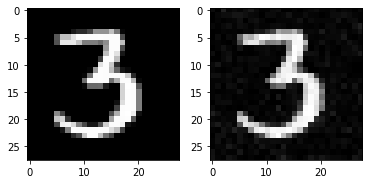

25  :  -0.09170300314947905 25
50  :  -0.09131920401440352 25
75  :  -0.09022735151329503 25
100  :  -0.09022735151329503 25
125  :  -0.09013209189867172 25
150  :  -0.09022735151329503 25
175  :  -0.09017388335116605 25
200  :  -0.09018347820965728 25
225  :  -0.08908428689643616 25
250  :  -0.08901049628904051 25
275  :  -0.08911127364599808 25
300  :  -0.08855047815820272 25
325  :  -0.08852009356770257 25
350  :  -0.08754069331060477 25
375  :  -0.08760012087825525 25
400  :  -0.08760012087825525 25
425  :  -0.08760012087825525 25
450  :  -0.08685330231220995 25
475  :  -0.08695085040618067 25
500  :  -0.08695085040618067 25
525  :  -0.08674351888050336 25
550  :  -0.0863299595270931 25
575  :  -0.0863299595270931 25
600  :  -0.0863299595270931 25
625  :  -0.08610806568804891 25
650  :  -0.08577073363514925 25
675  :  -0.08577073363514925 25
700  :  -0.08577073363514925 25
725  :  -0.08577073363514925 25
750  :  -0.08573303143433186 25
775  :  -0.08566393613879525 25
800  :  -0.085

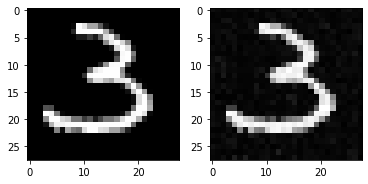

25  :  0.8516486822250133 25
50  :  0.8715632235250594 25
75  :  0.846082811924526 25
100  :  0.8359681677394426 25
125  :  0.8182069602680262 25
150  :  0.8380924353348258 25
175  :  0.8492093200232886 25
200  :  0.8541100834710444 25
225  :  0.8563460049619617 25
250  :  0.8669800091296913 25
275  :  0.8642353972927972 25
300  :  0.8782281710764275 25
325  :  0.8770086216157218 25
350  :  0.8780925175265907 25
375  :  0.8804133184629963 25
400  :  0.8811363216436684 25
425  :  0.8811363216436684 25
450  :  0.8811363216436684 25
475  :  0.8818550368151323 25
500  :  0.8842095436379714 25
525  :  0.8842095436379714 25
550  :  0.8853547521887455 25
575  :  0.8868957345239425 25
600  :  0.8867111768503357 25
625  :  0.8872248065557411 25
650  :  0.887040421766851 25
675  :  0.8880995929390192 25
700  :  0.8883312621090036 25
725  :  0.888827393755721 25
750  :  0.8898356065361993 25
775  :  0.8908141797107342 25
800  :  0.8908208722327907 25
825  :  0.8908208722327907 25
850  :  0.891183

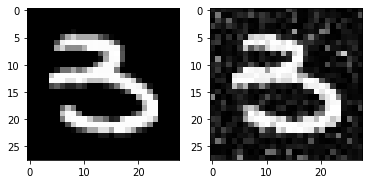

25  :  0.04566578493098883 25
50  :  0.07891784369526983 25
75  :  0.12121314298669861 25
100  :  0.29134076247622953 25
125  :  0.3126103110774718 25
150  :  0.3634988490462664 25
175  :  0.46914850566753397 25
200  :  0.5125159292957137 25
225  :  0.6310608658997464 25
250  :  0.618422463643771 25
275  :  0.6678661660477591 25
300  :  0.6678661660477591 25
325  :  0.6821185226529263 25
350  :  0.6783032723621322 25
375  :  0.6855859368275067 25
400  :  0.690128650771118 25
425  :  0.6991481703918615 25
450  :  0.7100720199609696 25
475  :  0.7100720199609696 25
500  :  0.7100720199609696 25
525  :  0.7113048815439861 25
550  :  0.713309405673385 25
575  :  0.714965963461637 25
600  :  0.714965963461637 25
625  :  0.7175395255106689 25
650  :  0.7199969325566673 25
675  :  0.7209267226678023 25
700  :  0.7209267226678023 25
725  :  0.7229217049089693 25
750  :  0.7231006204024699 25
775  :  0.7242510522808707 25
800  :  0.7252891696221377 25
825  :  0.7252891696221377 25
850  :  0.725

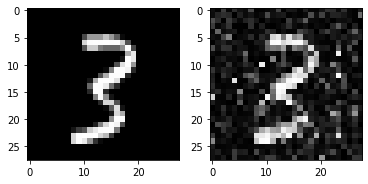

25  :  -0.12891376028938328 25
50  :  -0.12891376028938328 25
75  :  -0.1286964329729281 25
100  :  -0.12888096212071526 25
125  :  -0.12850083463463607 25
150  :  -0.12850083463463607 25
175  :  -0.12842259537722478 25
200  :  -0.12842259537722478 25
225  :  -0.12820283415139766 25
250  :  -0.12801615660058957 25
275  :  -0.12801615660058957 25
300  :  -0.12801615660058957 25
325  :  -0.1275530401333163 25
350  :  -0.12741822192675778 25
375  :  -0.12684715233632093 25
400  :  -0.12649561519711 25
425  :  -0.1263102141026013 25
450  :  -0.12628884338209306 25
475  :  -0.12627052373349928 25
500  :  -0.12628993105820985 25
525  :  -0.12598449875531292 25
550  :  -0.12598449875531292 25
575  :  -0.12598449875531292 25
600  :  -0.12598045140514808 25
625  :  -0.125863225578826 25
650  :  -0.1256833518660288 25
675  :  -0.1256833518660288 25
700  :  -0.12564699197978635 25
725  :  -0.1256470630313809 25
750  :  -0.12556970850477023 25
775  :  -0.1255063468207157 25
800  :  -0.125443096903

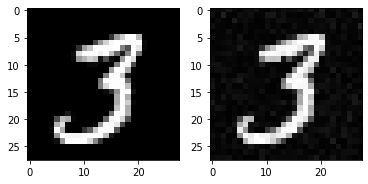

25  :  0.1364248963008005 25
50  :  0.6719777432364366 25
75  :  0.12932790645037145 25
100  :  0.3796632079583127 25
125  :  -0.08537753355270566 25
150  :  -0.07334589667717467 25
175  :  0.006483228401758023 25
200  :  -0.0844352399322138 25
225  :  -0.0844352399322138 25
250  :  -0.0844352399322138 25
275  :  -0.0844352399322138 25
300  :  -0.0844352399322138 25
325  :  -0.0844352399322138 25
350  :  -0.0844352399322138 25
375  :  -0.0844352399322138 25
400  :  -0.08279587448338765 25
425  :  -0.08311231961057419 25
450  :  -0.08311231961057419 25
475  :  -0.08311231961057419 25
500  :  -0.08311231961057419 25
525  :  -0.08311231961057419 25
550  :  -0.08311231961057419 25
575  :  -0.08266448831271894 25
600  :  -0.08308244459865088 25
625  :  -0.0824563316905928 25
650  :  -0.08251788302456442 25
675  :  -0.08251788302456442 25
700  :  -0.08251788302456442 25
725  :  -0.08251788302456442 25
750  :  -0.08250185057829984 25
775  :  -0.08241532214309732 25
800  :  -0.0824376405797683

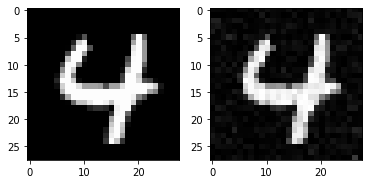

25  :  0.2575715558922322 25
50  :  0.6860692800143816 25
75  :  0.6457999809421151 25
100  :  0.6634694712569658 25
125  :  0.6659516011733726 25
150  :  0.6777301321276084 25
175  :  0.669274152604292 25
200  :  0.6563869016262589 25
225  :  0.648978531215874 25
250  :  0.6765596502718341 25
275  :  0.6775705769853981 25
300  :  0.708156695065814 25
325  :  0.7222969978043616 25
350  :  0.7222969978043616 25
375  :  0.7376240999081933 25
400  :  0.7454214015563004 25
425  :  0.7349093534504332 25
450  :  0.7392346615350964 25
475  :  0.7465541157826534 25
500  :  0.7504989830498293 25
525  :  0.7480137857168103 25
550  :  0.754271292452336 25
575  :  0.755850095213181 25
600  :  0.7587317110377636 25
625  :  0.7589018813457384 25
650  :  0.7638122203075595 25
675  :  0.7676329801973653 25
700  :  0.7676329801973653 25
725  :  0.7676329801973653 25
750  :  0.7684127373348432 25
775  :  0.7690507929160848 25
800  :  0.7698657906515414 25
825  :  0.7707568455102185 25
850  :  0.77141278

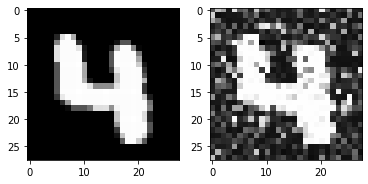

25  :  0.04546379329742878 25
50  :  0.543653416757542 25
75  :  0.1095615985113032 25
100  :  0.1419144469276824 25
125  :  0.39862734772286706 25
150  :  0.49920911986791494 25
175  :  0.5118755163380139 25
200  :  0.6328766530347794 25
225  :  0.6478593483259061 25
250  :  0.6464348003512348 25
275  :  0.6649431053831181 25
300  :  0.6661835016394733 25
325  :  0.6755157390754696 25
350  :  0.6816559440490289 25
375  :  0.6873547593831553 25
400  :  0.6948913714468419 25
425  :  0.6999435971754027 25
450  :  0.70575001022463 25
475  :  0.7060855716477785 25
500  :  0.7060855716477785 25
525  :  0.7088414037502572 25
550  :  0.7098562214790747 25
575  :  0.7117527356129012 25
600  :  0.7130325871990065 25
625  :  0.712865469688858 25
650  :  0.7135599803550844 25
675  :  0.7163760930095605 25
700  :  0.7163760930095605 25
725  :  0.7166708225776731 25
750  :  0.718966635191097 25
775  :  0.7201370388638932 25
800  :  0.7221120393842189 25
825  :  0.7226820189083892 25
850  :  0.72276

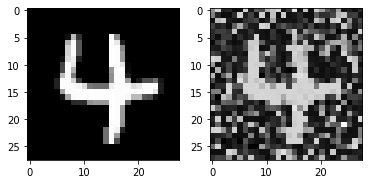

25  :  -0.04654557014738392 25
50  :  0.31853580968794915 25
75  :  -0.16529794346660387 25
100  :  -0.15743195523806064 25
125  :  -0.12370231159008527 25
150  :  -0.04569335849700712 25
175  :  0.13997516958545309 25
200  :  0.5007161746010106 25
225  :  0.5624338594848022 25
250  :  0.6046198392536416 25
275  :  0.6298074814534991 25
300  :  0.6447397005272151 25
325  :  0.6618579058780505 25
350  :  0.6808284524617101 25
375  :  0.6808284524617101 25
400  :  0.6808284524617101 25
425  :  0.6909359100012138 25
450  :  0.6940392810585572 25
475  :  0.6999294570376805 25
500  :  0.7034416843252144 25
525  :  0.7165505305539219 25
550  :  0.7169368081101916 25
575  :  0.7201128899001032 25
600  :  0.720005420004772 25
625  :  0.720005420004772 25
650  :  0.720321854659868 25
675  :  0.7203449135431755 25
700  :  0.7203449135431755 25
725  :  0.7208404069164823 25
750  :  0.7229797753182271 25
775  :  0.722974944096868 25
800  :  0.7248960681000282 25
825  :  0.7248367908095823 25
850  

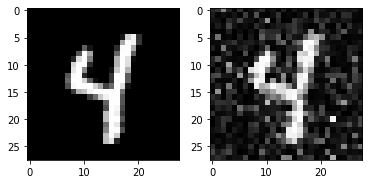

25  :  0.14146605161355685 25
50  :  0.5870003433395518 25
75  :  0.5865334004934111 25
100  :  0.6039685374215158 25
125  :  0.6138925965166655 25
150  :  0.6216343431092731 25
175  :  0.62403967869137 25
200  :  0.6157110053638929 25
225  :  0.6494003247943319 25
250  :  0.6417162151206395 25
275  :  0.6417162151206395 25
300  :  0.6450975511623889 25
325  :  0.6501489549417185 25
350  :  0.662846087776293 25
375  :  0.659991572752976 25
400  :  0.6737283510361938 25
425  :  0.6762396549434944 25
450  :  0.6732255436761275 25
475  :  0.6732255436761275 25
500  :  0.6732255436761275 25
525  :  0.6732255436761275 25
550  :  0.6775895129547446 25
575  :  0.679164873247073 25
600  :  0.679164873247073 25
625  :  0.679164873247073 25
650  :  0.679164873247073 25
675  :  0.6801295835173897 25
700  :  0.680584601936243 25
725  :  0.6812761515926983 25
750  :  0.681980976931713 25
775  :  0.6816160394925976 25
800  :  0.6824025533431847 25
825  :  0.6838835026603147 25
850  :  0.683894529672

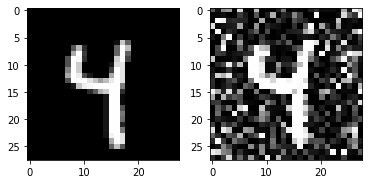

25  :  -0.05393139887340104 25
50  :  -0.02536366592628142 25
75  :  0.09030566240038307 25
100  :  0.12852172994014877 25
125  :  0.45933036915766357 25
150  :  0.5491147628335875 25
175  :  0.5806960829421403 25
200  :  0.6259633734964607 25
225  :  0.6414826187677847 25
250  :  0.6459152951258093 25
275  :  0.6490555327953555 25
300  :  0.6747948438007556 25
325  :  0.6866515533976243 25
350  :  0.69084263681656 25
375  :  0.6905255528060914 25
400  :  0.6919201306452559 25
425  :  0.7024031714958447 25
450  :  0.7082787540826033 25
475  :  0.7104338254986865 25
500  :  0.7113572701132207 25
525  :  0.7112340203521053 25
550  :  0.7114793799760339 25
575  :  0.7114712873996926 25
600  :  0.7118342502276983 25
625  :  0.7164870181791492 25
650  :  0.7170474707475276 25
675  :  0.7194221901606186 25
700  :  0.7214351182889038 25
725  :  0.7232652448079914 25
750  :  0.7252835119768106 25
775  :  0.7263336433780053 25
800  :  0.7271897715491049 25
825  :  0.7282721011589322 25
850  :  

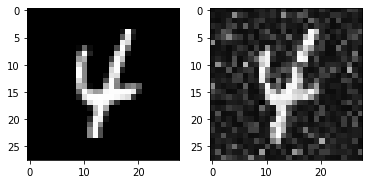

25  :  -0.11229006099641903 25
50  :  -0.11229006099641903 25
75  :  -0.10768276411996555 25
100  :  -0.09761637016784785 25
125  :  -0.08521600008440677 25
150  :  -0.036301772590150105 25
175  :  0.18702493759621736 25
200  :  0.46220572709435315 25
225  :  0.5153921319643164 25
250  :  0.5675041036448344 25
275  :  0.5565966606264682 25
300  :  0.5565966606264682 25
325  :  0.5833794751508337 25
350  :  0.5971221564459421 25
375  :  0.610140626392747 25
400  :  0.6566322880316355 25
425  :  0.6593968582808001 25
450  :  0.6593968582808001 25
475  :  0.6593968582808001 25
500  :  0.6593968582808001 25
525  :  0.6776697637489522 25
550  :  0.6859533798655817 25
575  :  0.6897203439130372 25
600  :  0.6909947026249534 25
625  :  0.6924266343530998 25
650  :  0.6928199164219229 25
675  :  0.6974184878977656 25
700  :  0.6990793385250932 25
725  :  0.7020071670727067 25
750  :  0.7066542125837929 25
775  :  0.7066545514258391 25
800  :  0.7074942305769013 25
825  :  0.7102196026968561 25

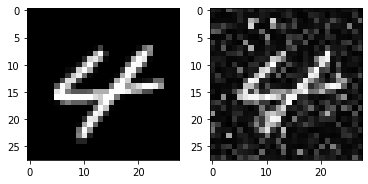

25  :  -0.06465344186728644 25
50  :  0.3925537545163469 25
75  :  0.021811168268189574 25
100  :  -0.13089642688494652 25
125  :  -0.1307922254623271 25
150  :  -0.13089411507499366 25
175  :  -0.12249315309165848 25
200  :  -0.10257932725003105 25
225  :  0.27530901561639837 25
250  :  0.5391605584810731 25
275  :  0.6749646245783958 25
300  :  0.6845923655639287 25
325  :  0.6942561925964412 25
350  :  0.6946278935143145 25
375  :  0.705293792175749 25
400  :  0.7158854265552823 25
425  :  0.7163625115102297 25
450  :  0.7169836604186945 25
475  :  0.7187564868851003 25
500  :  0.7187505256004619 25
525  :  0.7195674918657955 25
550  :  0.7223276396789183 25
575  :  0.7229033760818531 25
600  :  0.7230952768870225 25
625  :  0.7237997814545556 25
650  :  0.7238464512513916 25
675  :  0.7250997793145956 25
700  :  0.7251335887337802 25
725  :  0.7255998953929584 25
750  :  0.7255653282134016 25
775  :  0.7258494488351618 25
800  :  0.7258680562589221 25
825  :  0.7261189666362464 25


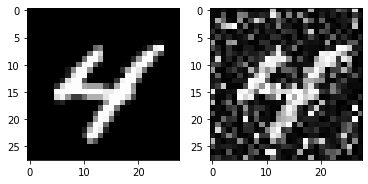

25  :  -0.103280947510964 25
50  :  0.19582585425488433 25
75  :  0.37180887461926876 25
100  :  0.5359282034997831 25
125  :  0.647303043958334 25
150  :  0.6637762584417101 25
175  :  0.6701080895492366 25
200  :  0.671956528765061 25
225  :  0.6700172087178268 25
250  :  0.6770152147976174 25
275  :  0.6724117611114226 25
300  :  0.6760197512429371 25
325  :  0.6765236413441869 25
350  :  0.6890128043662176 25
375  :  0.6863667707957306 25
400  :  0.6863667707957306 25
425  :  0.6863667707957306 25
450  :  0.6930430771954896 25
475  :  0.6950722987931349 25
500  :  0.694864465535452 25
525  :  0.694864465535452 25
550  :  0.6966996001941992 25
575  :  0.7001536796456211 25
600  :  0.7001536796456211 25
625  :  0.7001536796456211 25
650  :  0.702150152990995 25
675  :  0.701984598068156 25
700  :  0.701984598068156 25
725  :  0.7031667944148985 25
750  :  0.7055236065139909 25
775  :  0.706112010648244 25
800  :  0.7070646543573094 25
825  :  0.7104854920040794 25
850  :  0.710694767

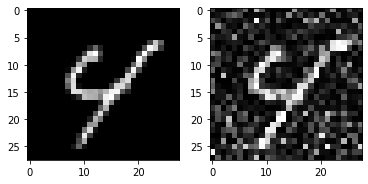

25  :  -0.0492694563319889 25
50  :  0.42960339500227607 25
75  :  -0.10307732086907284 25
100  :  0.05729823093724459 25
125  :  0.2072623994155141 25
150  :  0.5915192687638182 25
175  :  0.611165118452118 25
200  :  0.5760662234067458 25
225  :  0.5881204775840548 25
250  :  0.607952737939432 25
275  :  0.63944513222707 25
300  :  0.63944513222707 25
325  :  0.6657880511700466 25
350  :  0.6632664600785273 25
375  :  0.6632664600785273 25
400  :  0.6632664600785273 25
425  :  0.6742464772179365 25
450  :  0.6731251180005963 25
475  :  0.6764135193281018 25
500  :  0.6754874712260103 25
525  :  0.678044219559384 25
550  :  0.6793548934538739 25
575  :  0.6775830098279795 25
600  :  0.6960047823275256 25
625  :  0.6963462254810325 25
650  :  0.6971604660773264 25
675  :  0.6963625968104932 25
700  :  0.7061204879109528 25
725  :  0.7072229673606582 25
750  :  0.7072229673606582 25
775  :  0.7091654877173648 25
800  :  0.7087275588337963 25
825  :  0.7107039287016328 25
850  :  0.71332

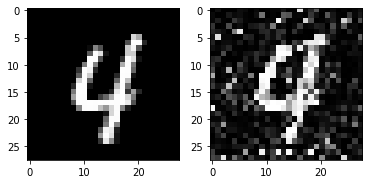

25  :  0.20909307491667184 25
50  :  0.5769077730244475 25
75  :  0.5677399383817294 25
100  :  0.5580284693754909 25
125  :  0.620741872652449 25
150  :  0.643035621473272 25
175  :  0.6366449959115109 25
200  :  0.6530976786644883 25
225  :  0.6532553015692723 25
250  :  0.6638187469276262 25
275  :  0.6643116383344578 25
300  :  0.6673551863218259 25
325  :  0.6654726085723968 25
350  :  0.6728309379910709 25
375  :  0.6743900429761223 25
400  :  0.6777075019778965 25
425  :  0.6788599705077326 25
450  :  0.6835113575678191 25
475  :  0.6864398493686086 25
500  :  0.6888825697152405 25
525  :  0.6888825697152405 25
550  :  0.6888825697152405 25
575  :  0.6921237199193634 25
600  :  0.6924552890763959 25
625  :  0.6924552890763959 25
650  :  0.6924552890763959 25
675  :  0.6946035017883787 25
700  :  0.6948292597119702 25
725  :  0.6948292597119702 25
750  :  0.6952651384451982 25
775  :  0.6954726513651834 25
800  :  0.6980655098984805 25
825  :  0.7003440811273154 25
850  :  0.7004

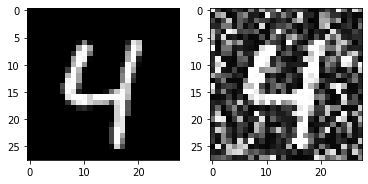

25  :  0.09058300768538799 25
50  :  0.6105376971753017 25
75  :  0.5495074665349386 25
100  :  0.6296126449380934 25
125  :  0.6317309562026676 25
150  :  0.6174314720692632 25
175  :  0.6428364902639254 25
200  :  0.6502385751278318 25
225  :  0.6549606972029811 25
250  :  0.6550140764873944 25
275  :  0.6638009815230623 25
300  :  0.6814828036510003 25
325  :  0.6860571424961585 25
350  :  0.6860571424961585 25
375  :  0.6860571424961585 25
400  :  0.69221525220195 25
425  :  0.693766393868697 25
450  :  0.6945874774881009 25
475  :  0.6977086509117953 25
500  :  0.6969975678939123 25
525  :  0.6969975678939123 25
550  :  0.6969975678939123 25
575  :  0.6969975678939123 25
600  :  0.6980293157459502 25
625  :  0.6977350019533235 25
650  :  0.7005515283631563 25
675  :  0.7015881034112335 25
700  :  0.7023948090418171 25
725  :  0.7026623360496989 25
750  :  0.7025916295137522 25
775  :  0.7025916295137522 25
800  :  0.7037137057449654 25
825  :  0.7044489385751302 25
850  :  0.70445

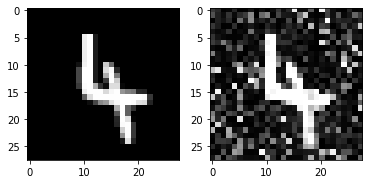

25  :  -0.033069508056489116 25
50  :  0.3740124112452603 25
75  :  0.27747592285055916 25
100  :  0.45356257421015844 25
125  :  0.533842794120476 25
150  :  0.5923225738414951 25
175  :  0.6452070117523537 25
200  :  0.6541380348759857 25
225  :  0.6541380348759857 25
250  :  0.660361325852115 25
275  :  0.6696315100127401 25
300  :  0.6794566181818048 25
325  :  0.6800325093945134 25
350  :  0.6800325093945134 25
375  :  0.6823315344486178 25
400  :  0.6823315344486178 25
425  :  0.683547102515422 25
450  :  0.6872411235806678 25
475  :  0.6872583176080854 25
500  :  0.6872583176080854 25
525  :  0.6934194397624057 25
550  :  0.6938073888859961 25
575  :  0.6938073888859961 25
600  :  0.6938073888859961 25
625  :  0.6938073888859961 25
650  :  0.6960754494401786 25
675  :  0.6960899299567966 25
700  :  0.6964631784104569 25
725  :  0.6974168828422633 25
750  :  0.6978766811288349 25
775  :  0.6980915182296278 25
800  :  0.6984672633547588 25
825  :  0.6988372807081344 25
850  :  0.6

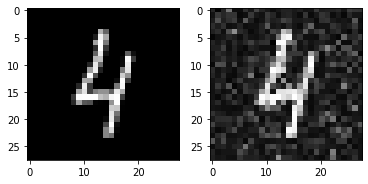

25  :  -0.15210202412497165 25
50  :  -0.15210202412497165 25
75  :  -0.14269745095545566 25
100  :  -0.1374379477642969 25
125  :  -0.1189522836406482 25
150  :  -0.10234442454106221 25
175  :  -0.057443501287169935 25
200  :  0.05267234298828388 25
225  :  0.08614810416209503 25
250  :  0.13209849035774415 25
275  :  0.1741849654576724 25
300  :  0.21212025257461478 25
325  :  0.2520957372954127 25
350  :  0.24819819540910854 25
375  :  0.24819819540910854 25
400  :  0.24819819540910854 25
425  :  0.3229310617548439 25
450  :  0.3514559307717706 25
475  :  0.3706817238706269 25
500  :  0.38041144942956573 25
525  :  0.3907365979531121 25
550  :  0.42600794948364185 25
575  :  0.42543595572932325 25
600  :  0.4269457669406419 25
625  :  0.4362702140479325 25
650  :  0.4369135296278067 25
675  :  0.43886372917078276 25
700  :  0.43842939696252226 25
725  :  0.4516374992949238 25
750  :  0.4691799812788383 25
775  :  0.46875212361480895 25
800  :  0.4836743938528736 25
825  :  0.4874273

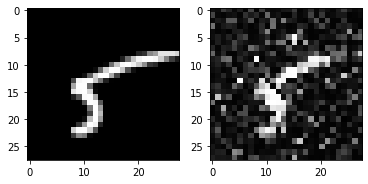

25  :  -0.04947301962245332 25
50  :  -0.024126292116661452 25
75  :  -0.03430753326310454 25
100  :  -0.012892080138093398 25
125  :  0.0629505194311869 25
150  :  0.2404936259357372 25
175  :  0.28370667106287756 25
200  :  0.45713059433314074 25
225  :  0.5320347969025323 25
250  :  0.5596051203683883 25
275  :  0.529512329265913 25
300  :  0.5488143690890557 25
325  :  0.6285465362234526 25
350  :  0.6159415225541185 25
375  :  0.6159415225541185 25
400  :  0.6173203150097828 25
425  :  0.6495799024211354 25
450  :  0.6474277838622591 25
475  :  0.6425967384957172 25
500  :  0.6503207051152764 25
525  :  0.6718480369043893 25
550  :  0.6744101017880542 25
575  :  0.6751863055978609 25
600  :  0.6748685925127104 25
625  :  0.6784677221550891 25
650  :  0.6838634411005972 25
675  :  0.6844060590229925 25
700  :  0.6862881490095466 25
725  :  0.6908615980522381 25
750  :  0.6916812710180015 25
775  :  0.6947076553766868 25
800  :  0.69560049293671 25
825  :  0.6984010679071825 25
850 

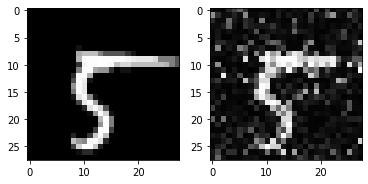

25  :  -0.05029034570201735 25
50  :  -0.05029034570201735 25
75  :  -0.04378801410744043 25
100  :  -0.03526467546668577 25
125  :  -0.014354844333938521 25
150  :  -0.008372897085836106 25
175  :  0.015997525472905116 25
200  :  0.13348269156854603 25
225  :  0.15088215746061956 25
250  :  0.14314543292421056 25
275  :  0.15254365188794378 25
300  :  0.2388164708233833 25
325  :  0.31835016980345976 25
350  :  0.36014096834155046 25
375  :  0.3680041539485883 25
400  :  0.42300218953005 25
425  :  0.41909979419636434 25
450  :  0.45724454719016727 25
475  :  0.4580288249712323 25
500  :  0.4914178220958891 25
525  :  0.4955718832233992 25
550  :  0.5548086111242 25
575  :  0.5764638311776418 25
600  :  0.5915489523266837 25
625  :  0.5982241346002436 25
650  :  0.6208279665490612 25
675  :  0.6316891869949324 25
700  :  0.6311330031716424 25
725  :  0.6361355986062456 25
750  :  0.6432755719471251 25
775  :  0.6495693603110482 25
800  :  0.6552909993091243 25
825  :  0.66460528968205

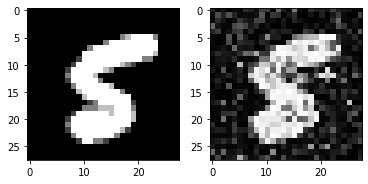

25  :  -0.06939813158016434 25
50  :  -0.06887194317872575 25
75  :  -0.06788817207639242 25
100  :  -0.06785005392207588 25
125  :  -0.0675434839332531 25
150  :  -0.0675434839332531 25
175  :  -0.06622467824915879 25
200  :  -0.06621817780984252 25
225  :  -0.06574338022812326 25
250  :  -0.06613066991150751 25
275  :  -0.06533807634557487 25
300  :  -0.06545683703300892 25
325  :  -0.06530574366266934 25
350  :  -0.06386473470868764 25
375  :  -0.06392775310601123 25
400  :  -0.06392775310601123 25
425  :  -0.06315684575032465 25
450  :  -0.06222655877903732 25
475  :  -0.06177995122963631 25
500  :  -0.05961466063232457 25
525  :  -0.05752264321661105 25
550  :  -0.05364687453072986 25
575  :  -0.026200370751272017 25
600  :  0.17113306209699108 25
625  :  0.2541688699146009 25
650  :  0.46394785619630047 25
675  :  0.5503370156247038 25
700  :  0.6190977818387007 25
725  :  0.6243058442801613 25
750  :  0.6274604203627714 25
775  :  0.6274604203627714 25
800  :  0.6521894174168298

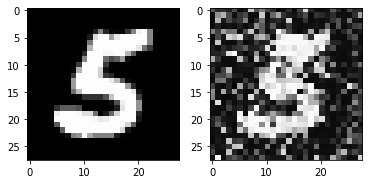

25  :  -0.0828320177171295 25
50  :  -0.08241882673960449 25
75  :  -0.07957789763517215 25
100  :  -0.07822867235521958 25
125  :  -0.07742671803872408 25
150  :  -0.07794364154946298 25
175  :  -0.07733259829886063 25
200  :  -0.07716961522034077 25
225  :  -0.07554995170751472 25
250  :  -0.07579798232809704 25
275  :  -0.07144426936533155 25
300  :  -0.07151018374190915 25
325  :  -0.06564905949474181 25
350  :  -0.05257688392370691 25
375  :  -0.0401715854105531 25
400  :  0.045076426709084794 25
425  :  0.13653890955724196 25
450  :  0.1637533119208982 25
475  :  0.2293919787993121 25
500  :  0.27144367714532486 25
525  :  0.2794319548057563 25
550  :  0.3293497744368657 25
575  :  0.3326508454331111 25
600  :  0.36353131239152126 25
625  :  0.3639470299323541 25
650  :  0.37819234903611076 25
675  :  0.4570442376707053 25
700  :  0.4646944875149027 25
725  :  0.5057327701764651 25
750  :  0.5058387404019135 25
775  :  0.5105110479366974 25
800  :  0.5265497626925673 25
825  :  0

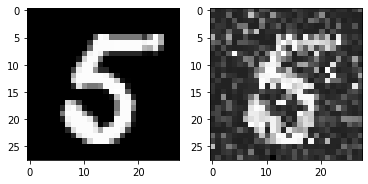

25  :  0.01800114216508042 25
50  :  0.029503597992400654 25
75  :  0.036318961759387314 25
100  :  0.12172714875686813 25
125  :  0.16573154565017573 25
150  :  0.23169947840984606 25
175  :  0.4365502791020741 25
200  :  0.4246170500654936 25
225  :  0.4776267558128978 25
250  :  0.5768533855038698 25
275  :  0.638182877166085 25
300  :  0.6586237102313539 25
325  :  0.6658301621584632 25
350  :  0.6847238396780646 25
375  :  0.701729744132268 25
400  :  0.7249798467683968 25
425  :  0.7249798467683968 25
450  :  0.7249798467683968 25
475  :  0.7416888664382976 25
500  :  0.7501689647220441 25
525  :  0.7501689647220441 25
550  :  0.7529411790171177 25
575  :  0.7610758738588284 25
600  :  0.7609060254640365 25
625  :  0.7609060254640365 25
650  :  0.7660445832636562 25
675  :  0.7689396586086628 25
700  :  0.7693408295271342 25
725  :  0.7762862941745838 25
750  :  0.7785109648417454 25
775  :  0.7785109648417454 25
800  :  0.7789474898081687 25
825  :  0.7805139062026033 25
850  : 

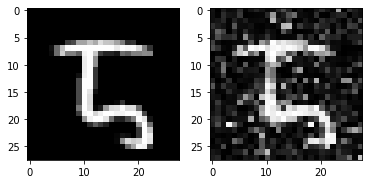

25  :  0.7920728084687643 25
50  :  0.7920728084687643 25
75  :  0.7994107284605901 25
100  :  0.7986560735298747 25
125  :  0.7988661710933372 25
150  :  0.8010684984185332 25
175  :  0.8053457484641279 25
200  :  0.8068540135045817 25
225  :  0.8070516579388269 25
250  :  0.8071234962593479 25
275  :  0.8102942085099137 25
300  :  0.8113712496216431 25
325  :  0.8114109805666893 25
350  :  0.8114109805666893 25
375  :  0.8121770325540136 25
400  :  0.8137464585413414 25
425  :  0.8141252369361394 25
450  :  0.8146348155735383 25
475  :  0.8145997392372301 25
500  :  0.8149668608541272 25
525  :  0.8158701902482786 25
550  :  0.8158403791120473 25
575  :  0.8168703429381593 25
600  :  0.8167487975144587 25
625  :  0.8167594963140434 25
650  :  0.8167265035480631 25
675  :  0.8167820393557441 25
700  :  0.816956077751673 25
725  :  0.817131675683129 25
750  :  0.8175382211746642 25
775  :  0.8175370984810393 25
800  :  0.8176705773871893 25
Time:  85.88274025917053  seconds
Predicted c

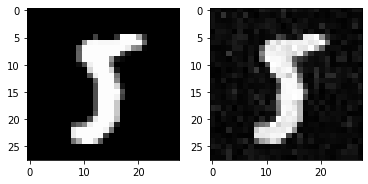

25  :  0.5325133180936248 25
50  :  0.5586506170032819 25
75  :  0.6223361675829693 25
100  :  0.6271917586583129 25
125  :  0.6680746638930785 25
150  :  0.6895267840395545 25
175  :  0.717118172717969 25
200  :  0.7296312156356719 25
225  :  0.7304136812737696 25
250  :  0.7331226598586229 25
275  :  0.7350251522610681 25
300  :  0.7354501034766853 25
325  :  0.7358625885079828 25
350  :  0.7373918332536629 25
375  :  0.7371004636986649 25
400  :  0.7403157025314375 25
425  :  0.7403157025314375 25
450  :  0.7403157025314375 25
475  :  0.7413015438286525 25
500  :  0.7412986474453227 25
525  :  0.7423369214478543 25
550  :  0.7426825536027857 25
575  :  0.7435886237532783 25
600  :  0.7442116017476643 25
625  :  0.7442159327519642 25
650  :  0.7442170733192983 25
675  :  0.7452418868711874 25
700  :  0.7452758651441147 25
725  :  0.7453857737951 25
750  :  0.7460395840475087 25
775  :  0.7461251666574569 25
800  :  0.7461348693924685 25
825  :  0.7464836132483572 25
850  :  0.7465807

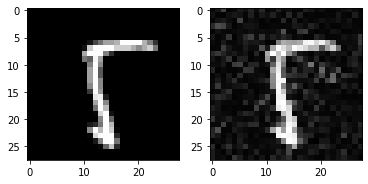

25  :  0.1892172894625021 25
50  :  0.2193920858610634 25
75  :  0.3100672191805822 25
100  :  0.4616128126094767 25
125  :  0.5220387600403484 25
150  :  0.6250779330768668 25
175  :  0.7029328729961579 25
200  :  0.7049099508011603 25
225  :  0.724364722371598 25
250  :  0.732102544767219 25
275  :  0.745049602247084 25
300  :  0.7535191310392847 25
325  :  0.773483116411015 25
350  :  0.7737547476667028 25
375  :  0.7742021408238587 25
400  :  0.7770597527798417 25
425  :  0.7809508953135231 25
450  :  0.7854006204709362 25
475  :  0.7858370399393004 25
500  :  0.7862968811073962 25
525  :  0.7863573579126135 25
550  :  0.789227635822857 25
575  :  0.788964917974059 25
600  :  0.7926253887154502 25
625  :  0.7937103661688532 25
650  :  0.794011241798988 25
675  :  0.7952924113132402 25
700  :  0.7953027992394107 25
725  :  0.7964852371320112 25
750  :  0.7964998096895212 25
775  :  0.7967179241994554 25
800  :  0.7982846720157386 25
825  :  0.7995402993858367 25
850  :  0.7995085672

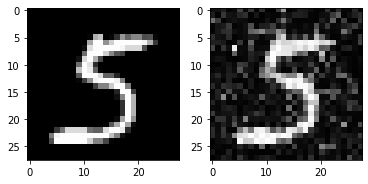

25  :  0.2816927898151808 25
50  :  0.3230388704951067 25
75  :  0.43539109634219053 25
100  :  0.47110932548504 25
125  :  0.47867327325045067 25
150  :  0.5398614419970336 25
175  :  0.6288642685420746 25
200  :  0.667953520450048 25
225  :  0.6806569450608965 25
250  :  0.7240603648551209 25
275  :  0.7277426185384245 25
300  :  0.7277426185384245 25
325  :  0.7288188435411225 25
350  :  0.7357495670605299 25
375  :  0.7438256104225741 25
400  :  0.7371537147154692 25
425  :  0.7520204652953117 25
450  :  0.7557550730342472 25
475  :  0.7589450594174706 25
500  :  0.7641172726667728 25
525  :  0.7753294189094817 25
550  :  0.781963460453198 25
575  :  0.78250539154921 25
600  :  0.78250539154921 25
625  :  0.7853643301114741 25
650  :  0.7902936056455043 25
675  :  0.791627646102709 25
700  :  0.7985218043904214 25
725  :  0.7985652549501726 25
750  :  0.7990895417621737 25
775  :  0.8030744208002877 25
800  :  0.8069794634022056 25
825  :  0.8073770945822905 25
850  :  0.8073421424

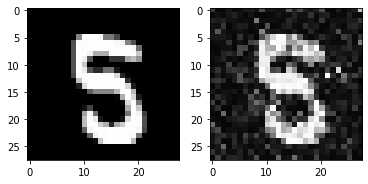

25  :  0.5135018569221381 25
50  :  0.5645188735570716 25
75  :  0.637131917152481 25
100  :  0.6343052107350046 25
125  :  0.6674365874036725 25
150  :  0.6957801417378544 25
175  :  0.7053911585754173 25
200  :  0.711591748180755 25
225  :  0.7121635458932242 25
250  :  0.7160110603945937 25
275  :  0.7160110603945937 25
300  :  0.7183753342062532 25
325  :  0.7183753342062532 25
350  :  0.7244701869118478 25
375  :  0.726172863755725 25
400  :  0.7270166648417105 25
425  :  0.7294012219224079 25
450  :  0.7300582770913092 25
475  :  0.730333377862603 25
500  :  0.7315598416819364 25
525  :  0.7322505734124115 25
550  :  0.7328851447385153 25
575  :  0.7336972551505561 25
600  :  0.733985597982065 25
625  :  0.7338852004260203 25
650  :  0.7357104109970595 25
675  :  0.7358893065628558 25
700  :  0.7358893065628558 25
725  :  0.736980847035178 25
750  :  0.7371673614788595 25
775  :  0.7371672048781777 25
800  :  0.737533747829942 25
825  :  0.7375885050439686 25
850  :  0.7376952967

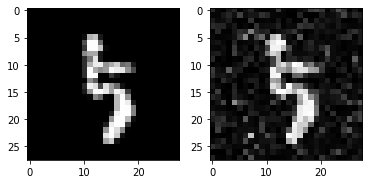

25  :  -0.04384045486503185 25
50  :  -0.024270653272422393 25
75  :  -0.03294658702211278 25
100  :  -0.03325603411169181 25
125  :  -0.023148513299936724 25
150  :  -0.01050540195210109 25
175  :  -0.0035939676972036594 25
200  :  -0.0012132770642392932 25
225  :  0.02259573432440659 25
250  :  0.07106030972792182 25
275  :  0.1936284365728686 25
300  :  0.4265368789617134 25
325  :  0.556022095315485 25
350  :  0.5868985992775877 25
375  :  0.5720695945481911 25
400  :  0.5943394090145037 25
425  :  0.5935860355219091 25
450  :  0.6142755523705647 25
475  :  0.6261776170786729 25
500  :  0.6281502499268631 25
525  :  0.6479325692960335 25
550  :  0.6553595247494166 25
575  :  0.665119299928738 25
600  :  0.6724643313830062 25
625  :  0.6741346033690034 25
650  :  0.6738449489473539 25
675  :  0.6738449489473539 25
700  :  0.6754984200493812 25
725  :  0.6811363903762937 25
750  :  0.6869995765563993 25
775  :  0.6915097170888918 25
800  :  0.6957242698364514 25
825  :  0.69755722261

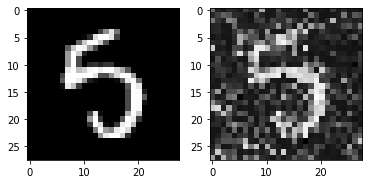

25  :  0.8395361990507967 25
50  :  0.8395361990507967 25
75  :  0.8502666108653656 25
100  :  0.8512858733470212 25
125  :  0.8590528496687024 25
150  :  0.8623830392479467 25
175  :  0.8600613296125038 25
200  :  0.8620481858440314 25
225  :  0.8609724630912303 25
250  :  0.8644475373927911 25
275  :  0.8685365032981769 25
300  :  0.8732692818624449 25
325  :  0.8730103206195174 25
350  :  0.8730103206195174 25
375  :  0.8746056748379172 25
400  :  0.8754472964767124 25
425  :  0.8761316364435602 25
450  :  0.878363737585605 25
475  :  0.8782197208875614 25
500  :  0.8784072252905109 25
525  :  0.8793430910014373 25
550  :  0.8795500345386039 25
575  :  0.8819077254357587 25
600  :  0.882066425364634 25
625  :  0.8820283035952808 25
650  :  0.8831051623141505 25
675  :  0.8833070335832608 25
700  :  0.8831436015463581 25
725  :  0.883608421304287 25
750  :  0.8852462084498504 25
775  :  0.8849046849011066 25
800  :  0.8861004967339662 25
825  :  0.8861004967339662 25
850  :  0.886100

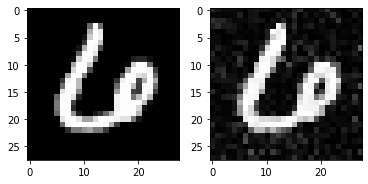

25  :  0.4166474728441297 25
50  :  0.6900651448274521 25
75  :  0.6337507092961716 25
100  :  0.6822646194464201 25
125  :  0.6842137275864733 25
150  :  0.6633191141513611 25
175  :  0.673905934077228 25
200  :  0.690428522343529 25
225  :  0.6977845694109157 25
250  :  0.7050346581036121 25
275  :  0.7037930732021578 25
300  :  0.7044482509941782 25
325  :  0.7136099760113623 25
350  :  0.7156815825910036 25
375  :  0.72122417075388 25
400  :  0.7302370717961523 25
425  :  0.7348158999660922 25
450  :  0.734267918193786 25
475  :  0.7344047854665097 25
500  :  0.7416073525275928 25
525  :  0.741552698992636 25
550  :  0.7440555910780631 25
575  :  0.7440555910780631 25
600  :  0.7445942830771247 25
625  :  0.7453332569432778 25
650  :  0.747798350168613 25
675  :  0.7491425826683347 25
700  :  0.750087173215716 25
725  :  0.7515819430823611 25
750  :  0.7527741982508087 25
775  :  0.7545685371410118 25
800  :  0.7545685371410118 25
825  :  0.7547780256645709 25
850  :  0.75686983197

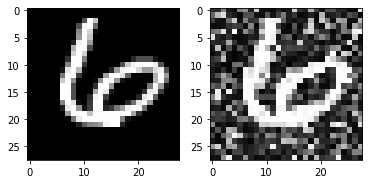

25  :  0.19574788352257433 25
50  :  0.670249290261682 25
75  :  0.5850290398994169 25
100  :  0.3688079399595638 25
125  :  0.47985169370210556 25
150  :  0.6759953493623692 25
175  :  0.5730800243836237 25
200  :  0.6160871699959324 25
225  :  0.5687613149809094 25
250  :  0.5663329864200095 25
275  :  0.2795745598443519 25
300  :  0.5501235054686113 25
325  :  -0.15343023340228074 25
350  :  -0.14065023267781063 25
375  :  -0.1532145795028435 25
400  :  -0.12230342279871903 25
425  :  0.24277344933109812 25
450  :  0.49788706294507723 25
475  :  0.6256229106540281 25
500  :  0.6660716640739595 25
525  :  0.6851467058390683 25
550  :  0.6752121300216791 25
575  :  0.6783966272262443 25
600  :  0.6888931690260746 25
625  :  0.7008339150408245 25
650  :  0.7013833747243711 25
675  :  0.701497507349387 25
700  :  0.7034971767177197 25
725  :  0.7034971767177197 25
750  :  0.7094819213717668 25
775  :  0.7098164621469307 25
800  :  0.718608795585608 25
825  :  0.7184198100313157 25
850  

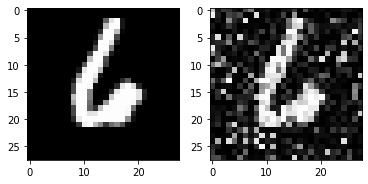

25  :  0.6161817049526379 25
50  :  0.7403066106746551 25
75  :  0.7236930794127956 25
100  :  0.7412983369037911 25
125  :  0.7413395912339309 25
150  :  0.7545132768048104 25
175  :  0.7571528342351193 25
200  :  0.7606973917080966 25
225  :  0.7606973917080966 25
250  :  0.7642811676046017 25
275  :  0.7615702182058167 25
300  :  0.765620193323542 25
325  :  0.7662863022224609 25
350  :  0.7700531758694451 25
375  :  0.7699307082143607 25
400  :  0.7713121326481813 25
425  :  0.7714787378128587 25
450  :  0.7716749008289588 25
475  :  0.7779541361432241 25
500  :  0.7795104035369211 25
525  :  0.7794338455039354 25
550  :  0.7794338455039354 25
575  :  0.7794338455039354 25
600  :  0.7810259413181928 25
625  :  0.7835328658636 25
650  :  0.7849942355061664 25
675  :  0.7852321177842491 25
700  :  0.7852321177842491 25
725  :  0.7852321177842491 25
750  :  0.7861254782243825 25
775  :  0.7864472466053538 25
800  :  0.7886552440432468 25
825  :  0.788717478707768 25
850  :  0.79002274

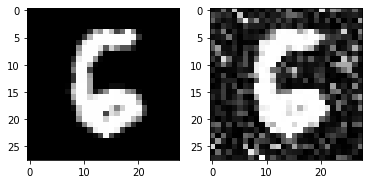

25  :  0.5445381926706188 25
50  :  0.6848782334787178 25
75  :  0.7189534776254275 25
100  :  0.691903232790546 25
125  :  0.6819523810974129 25
150  :  0.6912778853057683 25
175  :  0.6727734352351692 25
200  :  0.6945694751521367 25
225  :  0.6998085059289859 25
250  :  0.7090962174486479 25
275  :  0.7092687130532157 25
300  :  0.7092687130532157 25
325  :  0.7092687130532157 25
350  :  0.7092687130532157 25
375  :  0.7109445704822973 25
400  :  0.7167509276055151 25
425  :  0.7193334906081077 25
450  :  0.721458328701456 25
475  :  0.7225495184629389 25
500  :  0.7225495184629389 25
525  :  0.7225495184629389 25
550  :  0.7289922541088957 25
575  :  0.7287020381769543 25
600  :  0.7291343750350459 25
625  :  0.7291343750350459 25
650  :  0.7354151109619167 25
675  :  0.7359429968159933 25
700  :  0.7362790196435183 25
725  :  0.7404393963676342 25
750  :  0.7404393963676342 25
775  :  0.7419307035598941 25
800  :  0.7420192245745028 25
825  :  0.742833974418826 25
850  :  0.744795

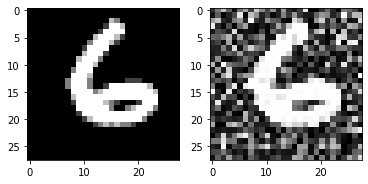

25  :  0.4454425880182135 25
50  :  0.716290094869676 25
75  :  0.6913608532812865 25
100  :  0.7148275651826593 25
125  :  0.709338280779453 25
150  :  0.7013538446065859 25
175  :  0.6882529905908545 25
200  :  0.6664749232180602 25
225  :  0.6715634898388194 25
250  :  0.6978041636097767 25
275  :  0.7053430563607169 25
300  :  0.7053430563607169 25
325  :  0.7053430563607169 25
350  :  0.7151025666952746 25
375  :  0.7296325910223238 25
400  :  0.7329837797734267 25
425  :  0.751555778382823 25
450  :  0.7560681542200323 25
475  :  0.7704899999528276 25
500  :  0.7704899999528276 25
525  :  0.7764433024314441 25
550  :  0.7772279804885909 25
575  :  0.7772279804885909 25
600  :  0.7791710579908524 25
625  :  0.7792664066005102 25
650  :  0.7808712143376575 25
675  :  0.7832788860984798 25
700  :  0.7876235825102056 25
725  :  0.7888932082366306 25
750  :  0.7896102017032147 25
775  :  0.790442673509917 25
800  :  0.7918222762389281 25
825  :  0.7924964802620305 25
850  :  0.7939531

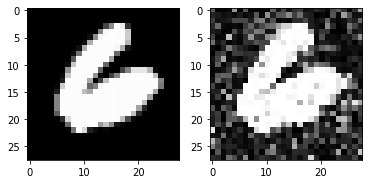

25  :  0.8163222184841123 25
50  :  0.8256861307109553 25
75  :  0.8111118393907737 25
100  :  0.8027637385199351 25
125  :  0.796531392509219 25
150  :  0.8112934337977683 25
175  :  0.8091537619468111 25
200  :  0.8165145064732109 25
225  :  0.821196264236088 25
250  :  0.821196264236088 25
275  :  0.821196264236088 25
300  :  0.821196264236088 25
325  :  0.823125707209061 25
350  :  0.8237826461003022 25
375  :  0.8260571634106771 25
400  :  0.8358970470463405 25
425  :  0.8363763184646618 25
450  :  0.8390959294796654 25
475  :  0.8393438386940549 25
500  :  0.8397008770426575 25
525  :  0.8396003377569705 25
550  :  0.8405410150025139 25
575  :  0.840665652512715 25
600  :  0.840831284387354 25
625  :  0.8423792310525782 25
650  :  0.8435233838966987 25
675  :  0.8434210036432527 25
700  :  0.8434528617429184 25
725  :  0.8443110136772798 25
750  :  0.8443043974317314 25
775  :  0.8457782657862494 25
800  :  0.8458003046321543 25
825  :  0.8464390096011687 25
850  :  0.84641632200

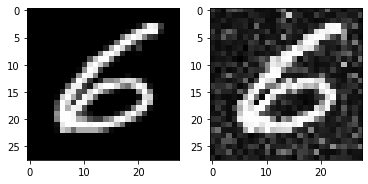

25  :  0.7131516401938003 25
50  :  0.7619772655776484 25
75  :  0.7270609464767746 25
100  :  0.7117780279117325 25
125  :  0.720180768675277 25
150  :  0.7087081143702424 25
175  :  0.7321456594120861 25
200  :  0.7336511490882056 25
225  :  0.7372307069723001 25
250  :  0.7403738495817553 25
275  :  0.7436672622479377 25
300  :  0.7437970012398183 25
325  :  0.7437970012398183 25
350  :  0.7469427575219174 25
375  :  0.7501567715113431 25
400  :  0.7546748887634331 25
425  :  0.7561894562809235 25
450  :  0.756238852844257 25
475  :  0.7580642747887409 25
500  :  0.7593884158602509 25
525  :  0.759815746390296 25
550  :  0.7600224315642188 25
575  :  0.7614824047549 25
600  :  0.7632721465209049 25
625  :  0.7653441010161373 25
650  :  0.7657520158636393 25
675  :  0.7674563469740734 25
700  :  0.7678908377185087 25
725  :  0.7687660001312657 25
750  :  0.7693436540553487 25
775  :  0.7694887585323973 25
800  :  0.7705032417211193 25
825  :  0.77135189819354 25
850  :  0.77173348397

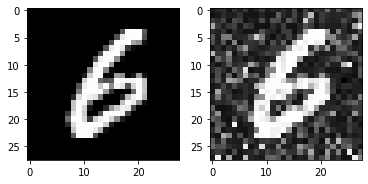

25  :  -0.16208761143583966 25
50  :  -0.16208761143583966 25
75  :  -0.16473810610563505 25
100  :  -0.16467427049583677 25
125  :  -0.16442562066715372 25
150  :  -0.16236244327912647 25
175  :  -0.16236244327912647 25
200  :  -0.16231472062159025 25
225  :  -0.16231472062159025 25
250  :  -0.16231472062159025 25
275  :  -0.161971636233332 25
300  :  -0.161971636233332 25
325  :  -0.16117345742189687 25
350  :  -0.16117345742189687 25
375  :  -0.16117345742189687 25
400  :  -0.16117345742189687 25
425  :  -0.16117345742189687 25
450  :  -0.16117345742189687 25
475  :  -0.16112572786583534 25
500  :  -0.1611264993112117 25
525  :  -0.16092431125773105 25
550  :  -0.16089326690014805 25
575  :  -0.16089433357571803 25
600  :  -0.16082984683350188 25
625  :  -0.16075546478101088 25
650  :  -0.16068533530826457 25
675  :  -0.16063597671195917 25
700  :  -0.1604986171794872 25
725  :  -0.16050286035605488 25
750  :  -0.16044399128252446 25
775  :  -0.1604068461467531 25
800  :  -0.1603903

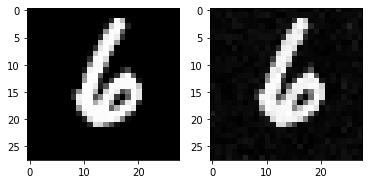

25  :  0.7606795491506368 25
50  :  0.7659661597746371 25
75  :  0.7041421149096891 25
100  :  0.7466873019639508 25
125  :  0.7299245437496427 25
150  :  0.7511765315092036 25
175  :  0.7524232587224717 25
200  :  0.7589856593322665 25
225  :  0.7610077947969367 25
250  :  0.760318934279713 25
275  :  0.7624270418989034 25
300  :  0.7638337839248208 25
325  :  0.771529607347154 25
350  :  0.7705831121521538 25
375  :  0.7706616323696592 25
400  :  0.7734076513926182 25
425  :  0.7747879638385411 25
450  :  0.7747879638385411 25
475  :  0.7747879638385411 25
500  :  0.7747879638385411 25
525  :  0.7747879638385411 25
550  :  0.7757474357506502 25
575  :  0.7762287667968003 25
600  :  0.7763696786224288 25
625  :  0.7772915955055157 25
650  :  0.7790011170932999 25
675  :  0.7789408820977182 25
700  :  0.7807676299498123 25
725  :  0.7811931901390938 25
750  :  0.7815204842117515 25
775  :  0.7816925487987748 25
800  :  0.7819790725434749 25
825  :  0.782118118762819 25
850  :  0.782727

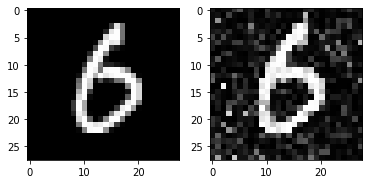

25  :  0.22798569732292423 25
50  :  0.6564806485255357 25
75  :  0.6260920613556649 25
100  :  0.6438419015365074 25
125  :  0.6452492436634084 25
150  :  0.6527342151062121 25
175  :  0.6639878829747432 25
200  :  0.6541804396300535 25
225  :  0.6744888560784956 25
250  :  0.6729643062080262 25
275  :  0.6964762652145629 25
300  :  0.7117636308641115 25
325  :  0.6879293041293264 25
350  :  0.6881327120167043 25
375  :  0.6881327120167043 25
400  :  0.6952602826838732 25
425  :  0.7005813303598515 25
450  :  0.7012351016054751 25
475  :  0.7012351016054751 25
500  :  0.7038345610513992 25
525  :  0.7075216318201807 25
550  :  0.7108448165625374 25
575  :  0.7107870287786199 25
600  :  0.7107870287786199 25
625  :  0.7112784827853769 25
650  :  0.7117967209142948 25
675  :  0.712813434109579 25
700  :  0.7131183809604275 25
725  :  0.7137164690301774 25
750  :  0.715644854264474 25
775  :  0.7156316238717811 25
800  :  0.7182118075033818 25
825  :  0.7186360740858098 25
850  :  0.7186

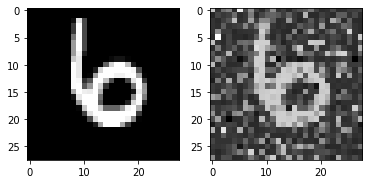

25  :  0.6355420541418185 25
50  :  0.6997936952137651 25
75  :  0.6205357054736915 25
100  :  0.6628243168739771 25
125  :  0.6597310226679544 25
150  :  0.6558307836100297 25
175  :  0.6668923608062604 25
200  :  0.6730275841923132 25
225  :  0.6783603177785806 25
250  :  0.6868386188553616 25
275  :  0.6868386188553616 25
300  :  0.6868386188553616 25
325  :  0.6868386188553616 25
350  :  0.6888798670627667 25
375  :  0.6902677174425591 25
400  :  0.6919298270156857 25
425  :  0.7016823024287825 25
450  :  0.7019336301969711 25
475  :  0.7022294104043749 25
500  :  0.7027067275523735 25
525  :  0.7041378719227471 25
550  :  0.7064164666349053 25
575  :  0.7117610556654939 25
600  :  0.7126093423414004 25
625  :  0.7134939731399961 25
650  :  0.7134939731399961 25
675  :  0.7134939731399961 25
700  :  0.7134939731399961 25
725  :  0.7143001789145861 25
750  :  0.7168157383284885 25
775  :  0.7168157383284885 25
800  :  0.7176119759505815 25
825  :  0.7192576158435892 25
850  :  0.720

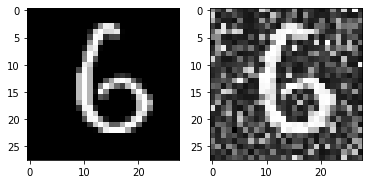

25  :  0.5539464655491874 25
50  :  0.6971036461234165 25
75  :  0.6599700845979977 25
100  :  0.656348318314664 25
125  :  0.6532990413837959 25
150  :  0.6804839385610535 25
175  :  0.6339399013466637 25
200  :  0.6397383581135635 25
225  :  0.6456268260124909 25
250  :  0.6516164428349417 25
275  :  0.6570872614467498 25
300  :  0.6796740540818463 25
325  :  0.6908611264798565 25
350  :  0.6920227551905197 25
375  :  0.6920227551905197 25
400  :  0.6983553708929849 25
425  :  0.7005406152123719 25
450  :  0.7022985007307422 25
475  :  0.7038039186275401 25
500  :  0.7075998849540678 25
525  :  0.7094234904197138 25
550  :  0.714742918439494 25
575  :  0.7154661420460506 25
600  :  0.7154661420460506 25
625  :  0.7154661420460506 25
650  :  0.7154661420460506 25
675  :  0.7177333419963058 25
700  :  0.7186580559124915 25
725  :  0.7204913757300747 25
750  :  0.7213007666932844 25
775  :  0.7214857497954286 25
800  :  0.7221122470664835 25
825  :  0.7219893585713216 25
850  :  0.72511

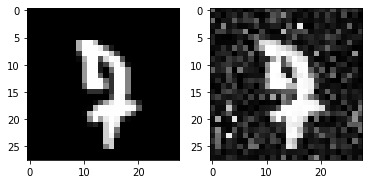

25  :  0.6823430500267802 25
50  :  0.7335716358742868 25
75  :  0.6856603523086753 25
100  :  0.6970108802089898 25
125  :  0.7283293590638706 25
150  :  0.7725894700019256 25
175  :  0.7634690208284141 25
200  :  0.7682245852593435 25
225  :  0.7902508161177022 25
250  :  0.8199781533570558 25
275  :  0.8054394616257567 25
300  :  0.8054394616257567 25
325  :  0.8054394616257567 25
350  :  0.808230373956586 25
375  :  0.808410801542645 25
400  :  0.8181141787568866 25
425  :  0.8161341360430134 25
450  :  0.8163510088506021 25
475  :  0.8311393775544207 25
500  :  0.8316437882101088 25
525  :  0.8401780040670987 25
550  :  0.8421750684953246 25
575  :  0.8449355788195972 25
600  :  0.8556350504387191 25
625  :  0.8552819151379242 25
650  :  0.8555077736761114 25
675  :  0.8583552304747508 25
700  :  0.8614267398674127 25
725  :  0.8611208150512222 25
750  :  0.8649266853490136 25
775  :  0.8674092723941564 25
800  :  0.867374918002268 25
825  :  0.867374918002268 25
850  :  0.8685189

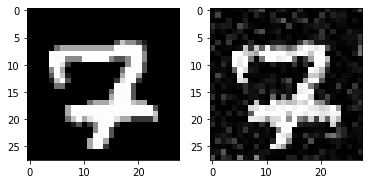

25  :  0.0012272421920612453 25
50  :  0.6221696957763267 25
75  :  0.18950380048187865 25
100  :  0.2777602620084658 25
125  :  0.4091359642111315 25
150  :  0.6488778807018112 25
175  :  0.6887823370175488 25
200  :  0.696532383674261 25
225  :  0.7129048684596221 25
250  :  0.7254086174741478 25
275  :  0.7277990414321072 25
300  :  0.7287029925905588 25
325  :  0.7287029925905588 25
350  :  0.7287029925905588 25
375  :  0.7355394843868077 25
400  :  0.7363914632587418 25
425  :  0.7411185517339394 25
450  :  0.7413771145711439 25
475  :  0.7413771145711439 25
500  :  0.7413771145711439 25
525  :  0.7420200614791381 25
550  :  0.7433397797136657 25
575  :  0.7444989644891761 25
600  :  0.7445097803796963 25
625  :  0.7450101049560234 25
650  :  0.7449814814219932 25
675  :  0.746052731793373 25
700  :  0.7474990268927294 25
725  :  0.7487204624226339 25
750  :  0.748800996398086 25
775  :  0.7493867105986718 25
800  :  0.7495405666292986 25
825  :  0.7504114129415176 25
850  :  0.75

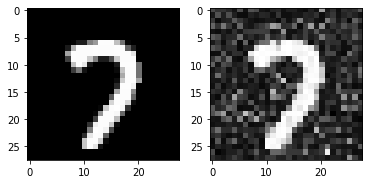

25  :  -0.10845260394044423 25
50  :  0.2063032364909977 25
75  :  -0.16150953534049378 25
100  :  -0.17144165261950783 25
125  :  -0.1711170342051791 25
150  :  -0.17080838207695226 25
175  :  -0.17065298742269308 25
200  :  -0.17078527669955834 25
225  :  -0.17029440902220894 25
250  :  -0.17007545753849612 25
275  :  -0.17021219664985832 25
300  :  -0.16975170970288522 25
325  :  -0.16975170970288522 25
350  :  -0.16975170970288522 25
375  :  -0.16975170970288522 25
400  :  -0.1686263443482383 25
425  :  -0.1686263443482383 25
450  :  -0.1686263443482383 25
475  :  -0.1686263443482383 25
500  :  -0.16815502614341055 25
525  :  -0.16815114216479532 25
550  :  -0.16774809885041758 25
575  :  -0.16782172942868723 25
600  :  -0.16741959987497462 25
625  :  -0.16741973940732918 25
650  :  -0.16741973940732918 25
675  :  -0.16741973940732918 25
700  :  -0.16741973940732918 25
725  :  -0.16738922862947014 25
750  :  -0.16724028676102298 25
775  :  -0.16723599734426847 25
800  :  -0.1672413

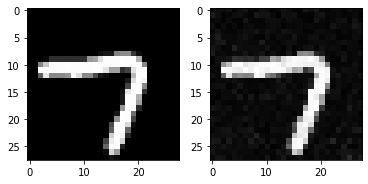

25  :  -0.1331188583846502 25
50  :  -0.13252903459230514 25
75  :  -0.13287221226441837 25
100  :  -0.13257326464471808 25
125  :  -0.13225692200098899 25
150  :  -0.13215789044648113 25
175  :  -0.13135151238841486 25
200  :  -0.07277725556767545 25
225  :  0.000656449255916236 25
250  :  0.05443119909344735 25
275  :  -0.13076101627819992 25
300  :  -0.13039579761648373 25
325  :  -0.13039579761648373 25
350  :  -0.13039579761648373 25
375  :  -0.1300326507935889 25
400  :  -0.13001552066637756 25
425  :  -0.13009189355143608 25
450  :  -0.13009189355143608 25
475  :  -0.13009189355143608 25
500  :  -0.1299145255847194 25
525  :  -0.12993903359563247 25
550  :  -0.12964786564751507 25
575  :  -0.12964786564751507 25
600  :  -0.12917194764884793 25
625  :  -0.12912892674666226 25
650  :  -0.1290752309047168 25
675  :  -0.1290752309047168 25
700  :  -0.1290752309047168 25
725  :  -0.1290752309047168 25
750  :  -0.1289476671478786 25
775  :  -0.1288711244469562 25
800  :  -0.1287784690

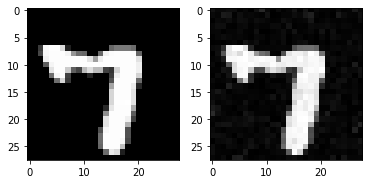

25  :  0.5662689407914835 25
50  :  0.5662689407914835 25
75  :  0.5617313861163828 25
100  :  0.5369973150023232 25
125  :  0.5755019355841882 25
150  :  0.5803878101884494 25
175  :  0.6152259330321639 25
200  :  0.5950132214288328 25
225  :  0.5962297817420021 25
250  :  0.5974232340302081 25
275  :  0.6108533725325271 25
300  :  0.6224244874112528 25
325  :  0.6226619438667894 25
350  :  0.6197881169172544 25
375  :  0.6256949380778407 25
400  :  0.6309099622250189 25
425  :  0.6413167207534831 25
450  :  0.6440905290133687 25
475  :  0.6470216721426921 25
500  :  0.644698695526801 25
525  :  0.6516431188256119 25
550  :  0.6548699237188831 25
575  :  0.6599584458988931 25
600  :  0.6633195666943896 25
625  :  0.6641619730660889 25
650  :  0.6634429122222202 25
675  :  0.6634429122222202 25
700  :  0.6646902819906424 25
725  :  0.6650229242046913 25
750  :  0.6669724802415576 25
775  :  0.6664106405371815 25
800  :  0.6675130481556468 25
825  :  0.6728663510878969 25
850  :  0.6730

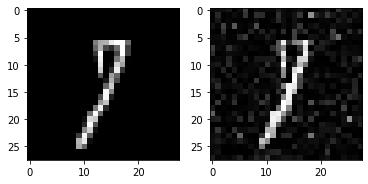

25  :  0.5321456692871467 25
50  :  0.5321456692871467 25
75  :  0.7056041949471707 25
100  :  0.7065752993905954 25
125  :  0.7591125111541077 25
150  :  0.7715314463569019 25
175  :  0.7761804817969333 25
200  :  0.7761804817969333 25
225  :  0.7766573040213105 25
250  :  0.7779043521079136 25
275  :  0.7833223652952709 25
300  :  0.7833223652952709 25
325  :  0.7865312366618531 25
350  :  0.7875888233997883 25
375  :  0.793859038238959 25
400  :  0.7932326414074361 25
425  :  0.7942523875827152 25
450  :  0.7950982651720013 25
475  :  0.7950982651720013 25
500  :  0.7950982651720013 25
525  :  0.796181862238427 25
550  :  0.8012600252226048 25
575  :  0.8011369765262464 25
600  :  0.8012924925903613 25
625  :  0.8011369765262464 25
650  :  0.8031012521112135 25
675  :  0.8035505051333145 25
700  :  0.8034139522306425 25
725  :  0.8047990151822538 25
750  :  0.8062576022444653 25
775  :  0.8065277409275611 25
800  :  0.8067923704066372 25
825  :  0.8073951438610439 25
850  :  0.80732

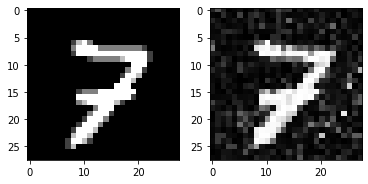

25  :  0.03129253267594456 25
50  :  0.668383023564689 25
75  :  0.4327879485814782 25
100  :  0.6756390390626836 25
125  :  0.6804249229793576 25
150  :  0.6607919330328714 25
175  :  0.6931550305812999 25
200  :  0.7044350932033463 25
225  :  0.7192329065825915 25
250  :  0.7251516227791897 25
275  :  0.7251516227791897 25
300  :  0.7267573534991261 25
325  :  0.7295082301863687 25
350  :  0.7295082301863687 25
375  :  0.7318311562336985 25
400  :  0.7330719468889125 25
425  :  0.7335078036721768 25
450  :  0.7361067195615457 25
475  :  0.7383202442687866 25
500  :  0.7383202442687866 25
525  :  0.7394630474709178 25
550  :  0.7392704726869141 25
575  :  0.7395979663173983 25
600  :  0.7395899970357818 25
625  :  0.7401522092349947 25
650  :  0.7401606506809106 25
675  :  0.7413683111877251 25
700  :  0.7429575957413627 25
725  :  0.744049943077219 25
750  :  0.7453786561840001 25
775  :  0.7465238740554125 25
800  :  0.74874144291815 25
825  :  0.7487049864723248 25
850  :  0.748704

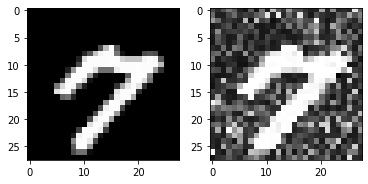

25  :  -0.1526785130711215 25
50  :  -0.1519547404050829 25
75  :  -0.15183154277845068 25
100  :  -0.1518426757657772 25
125  :  -0.15118001528026437 25
150  :  -0.1509800693192037 25
175  :  -0.15069353933973623 25
200  :  -0.15057789310618314 25
225  :  -0.14938921556037033 25
250  :  -0.14943182990282944 25
275  :  -0.14963991696685552 25
300  :  -0.1483013759984903 25
325  :  -0.1483013759984903 25
350  :  -0.1481689449290487 25
375  :  -0.14816897303757343 25
400  :  -0.1480825698143463 25
425  :  -0.14777218512794527 25
450  :  -0.14792162075952053 25
475  :  -0.1476724367992382 25
500  :  -0.14710973371732022 25
525  :  -0.14739093346372428 25
550  :  -0.14718877790837676 25
575  :  -0.1470173593591359 25
600  :  -0.14666232736867446 25
625  :  -0.146579499746272 25
650  :  -0.14645011603264946 25
675  :  -0.14640514656700626 25
700  :  -0.14635882759993213 25
725  :  -0.14623708153753978 25
750  :  -0.14617442231910144 25
775  :  -0.14617759058951296 25
800  :  -0.146110946820

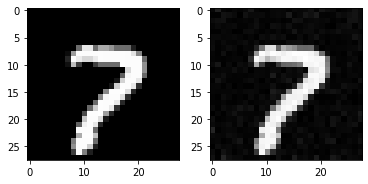

25  :  -0.17783535495640523 25
50  :  -0.17783535495640523 25
75  :  -0.17783535495640523 25
100  :  -0.17783535495640523 25
125  :  -0.17647880038064606 25
150  :  -0.17968424675176842 25
175  :  -0.1784854094212247 25
200  :  -0.17936405107226056 25
225  :  -0.17936405107226056 25
250  :  -0.17936405107226056 25
275  :  -0.17780603182599264 25
300  :  -0.17707510517026387 25
325  :  -0.17162919567165896 25
350  :  -0.1511740584761001 25
375  :  -0.12599312891419162 25
400  :  0.05633888347406635 25
425  :  0.4651020828974704 25
450  :  0.5609360628876963 25
475  :  0.6128180080278693 25
500  :  0.6119126662819516 25
525  :  0.6126569736058918 25
550  :  0.6355653449117629 25
575  :  0.6494055937583554 25
600  :  0.6534737506582686 25
625  :  0.6546849147802627 25
650  :  0.663155851294064 25
675  :  0.6815769662210059 25
700  :  0.6829613916102923 25
725  :  0.6835039148310851 25
750  :  0.6884971563911311 25
775  :  0.69143342193829 25
800  :  0.6928815241695325 25
825  :  0.6928815

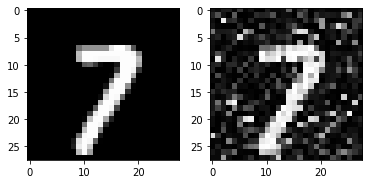

25  :  -0.11348338966620672 25
50  :  0.1758020738573397 25
75  :  0.37838401704373403 25
100  :  0.45190912205566414 25
125  :  0.6521276427300646 25
150  :  0.6766480192528483 25
175  :  0.6766480192528483 25
200  :  0.6766480192528483 25
225  :  0.6796661835557335 25
250  :  0.6807802393050018 25
275  :  0.6891821654550687 25
300  :  0.6895708069532577 25
325  :  0.6895708069532577 25
350  :  0.6907564889817642 25
375  :  0.6920070616578369 25
400  :  0.6920475183875868 25
425  :  0.6939430004655476 25
450  :  0.6940508966790081 25
475  :  0.6940508966790081 25
500  :  0.6963027188226929 25
525  :  0.6965353726356193 25
550  :  0.6978043374488485 25
575  :  0.6981157385585721 25
600  :  0.6994559345877668 25
625  :  0.6996505158089914 25
650  :  0.6996505301946728 25
675  :  0.701546778773273 25
700  :  0.7015467458780915 25
725  :  0.7015467458780915 25
750  :  0.7015467458780915 25
775  :  0.7027232418355265 25
800  :  0.7028138874370786 25
825  :  0.7041271630152504 25
850  :  0.

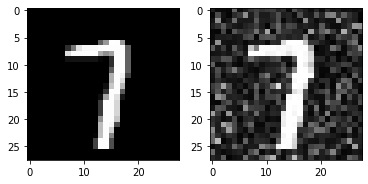

25  :  -0.21961633619468662 25
50  :  -0.21961633619468662 25
75  :  -0.21919059865494717 25
100  :  -0.21915958192645663 25
125  :  -0.21229793277279807 25
150  :  -0.16558172354240486 25
175  :  -0.14610496177117757 25
200  :  0.10193925395013986 25
225  :  0.556085009635154 25
250  :  0.6275773710162798 25
275  :  0.6522861140480509 25
300  :  0.6662560781514659 25
325  :  0.6662560781514659 25
350  :  0.6662560781514659 25
375  :  0.6682697500339498 25
400  :  0.6739026219986228 25
425  :  0.6754811362294539 25
450  :  0.6784260592637958 25
475  :  0.6798325280059407 25
500  :  0.6798325280059407 25
525  :  0.6818039490816034 25
550  :  0.6833539362109332 25
575  :  0.6841107048662514 25
600  :  0.6852166407824924 25
625  :  0.6859798336614011 25
650  :  0.687709149740126 25
675  :  0.6893874781526592 25
700  :  0.689716927364479 25
725  :  0.6923551181802149 25
750  :  0.6923398122352683 25
775  :  0.6937351986141344 25
800  :  0.6937351986141344 25
825  :  0.6937351986141344 25
8

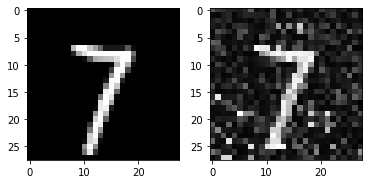

25  :  -0.1422921206917952 25
50  :  0.029133757211199374 25
75  :  0.11873419755825654 25
100  :  0.471416846741721 25
125  :  0.5788575881069185 25
150  :  0.6089636827299492 25
175  :  0.618172073512693 25
200  :  0.6252138374308981 25
225  :  0.6284938560174353 25
250  :  0.6317189034496102 25
275  :  0.6427442209943509 25
300  :  0.6451435261924784 25
325  :  0.6477531699203634 25
350  :  0.6533768356587906 25
375  :  0.6553518424893344 25
400  :  0.6553222080273938 25
425  :  0.65606954898083 25
450  :  0.6590382258315768 25
475  :  0.661590835166104 25
500  :  0.6624630139230969 25
525  :  0.6628787177322488 25
550  :  0.6633864397344243 25
575  :  0.6641724780811972 25
600  :  0.6650939640573185 25
625  :  0.6652867344359416 25
650  :  0.6655872279571609 25
675  :  0.6666945144102289 25
700  :  0.6669019136056615 25
725  :  0.6674315662928973 25
750  :  0.6677056016234904 25
775  :  0.668157537837551 25
800  :  0.6690537096697124 25
825  :  0.669238891216533 25
850  :  0.669922

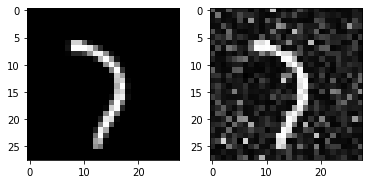

25  :  0.3078614602053371 25
50  :  0.6546324359974062 25
75  :  0.6128012542267365 25
100  :  0.6441288996426121 25
125  :  0.289591694595049 25
150  :  -0.17400649278245517 25
175  :  -0.1393541824066139 25
200  :  0.20038232198711237 25
225  :  0.4447000554405818 25
250  :  -0.1801969896935699 25
275  :  -0.17522136222883045 25
300  :  -0.1814488487332363 25
325  :  -0.17170613271414875 25
350  :  -0.1816212144968522 25
375  :  0.6387310586178221 25
400  :  -0.18126200202660192 25
425  :  0.6722136838868363 25
450  :  -0.02065475912957876 25
475  :  0.4286105921096972 25
500  :  0.6498785091883028 25
525  :  0.6588522949086573 25
550  :  0.6646150175162817 25
575  :  0.6739341452868092 25
600  :  0.6810120724569141 25
625  :  0.6962603580613328 25
650  :  0.7006747568323843 25
675  :  0.699738642217769 25
700  :  0.714046808745068 25
725  :  0.701899037886458 25
750  :  0.6998005733389814 25
775  :  0.7026160434174583 25
800  :  0.7012637136031635 25
825  :  0.704648620260355 25
850

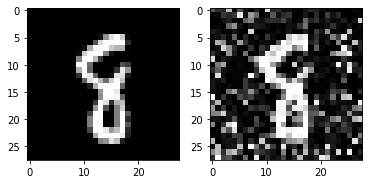

25  :  -0.02445863908473872 25
50  :  0.6667456293445877 25
75  :  0.48103643676428376 25
100  :  0.40630332676283537 25
125  :  0.5741945104568552 25
150  :  0.30064430174050116 25
175  :  0.5629211601063654 25
200  :  0.5633905279934084 25
225  :  0.575104887585027 25
250  :  0.6397067918465401 25
275  :  0.6241545054800225 25
300  :  0.6465205643988542 25
325  :  0.6577386674249855 25
350  :  0.6577386674249855 25
375  :  0.6768178285078678 25
400  :  0.6732363480577354 25
425  :  0.6827597503225984 25
450  :  0.6908757412513242 25
475  :  0.6994423383326784 25
500  :  0.708036598608478 25
525  :  0.7164188534278665 25
550  :  0.7245197003536632 25
575  :  0.724957700646202 25
600  :  0.7273785095378456 25
625  :  0.7283869547099254 25
650  :  0.7314718175066778 25
675  :  0.7345874306699691 25
700  :  0.7345874306699691 25
725  :  0.7395869493248413 25
750  :  0.7395914567546277 25
775  :  0.7399875835953438 25
800  :  0.7416916957871791 25
825  :  0.7426202943925913 25
850  :  0.7

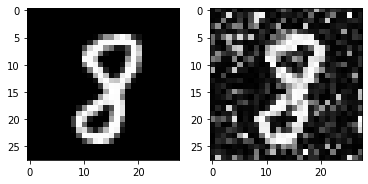

25  :  0.29848646584685196 25
50  :  0.6867882168557659 25
75  :  0.6706115029957869 25
100  :  0.629531650398728 25
125  :  0.5902211372598831 25
150  :  0.631874642355905 25
175  :  0.6550856819319779 25
200  :  0.5692058735175796 25
225  :  0.6415240379008256 25
250  :  0.6330088316940877 25
275  :  0.6785210027755003 25
300  :  0.6750217253787278 25
325  :  0.6857229474595495 25
350  :  0.6869177548204128 25
375  :  0.7101488258079809 25
400  :  0.7073787138595479 25
425  :  0.7075238466241621 25
450  :  0.7203617198609336 25
475  :  0.7264424147301507 25
500  :  0.736662358763318 25
525  :  0.7356867465272621 25
550  :  0.7438536748022577 25
575  :  0.7442552132031337 25
600  :  0.7459912970466923 25
625  :  0.7465427911447808 25
650  :  0.7484948518471692 25
675  :  0.7484927259261698 25
700  :  0.7511320797450014 25
725  :  0.7512794866788827 25
750  :  0.7524439556180377 25
775  :  0.7529198318515701 25
800  :  0.7548787773085966 25
825  :  0.7564771143999252 25
850  :  0.75667

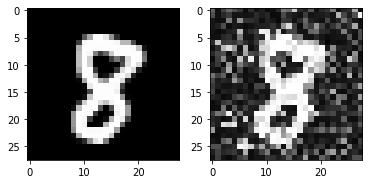

25  :  0.7326165003610252 25
50  :  0.7439872009817649 25
75  :  0.714108557315148 25
100  :  0.7206268193273754 25
125  :  0.7280489897541997 25
150  :  0.7315838540190338 25
175  :  0.7358705163283923 25
200  :  0.7221990406808189 25
225  :  0.7157068861073692 25
250  :  0.7208809965199734 25
275  :  0.727753489260527 25
300  :  0.7326898102998606 25
325  :  0.731752693775039 25
350  :  0.731752693775039 25
375  :  0.7336211818904546 25
400  :  0.7349520628175314 25
425  :  0.7390505684388154 25
450  :  0.7430604895310791 25
475  :  0.7489499036637017 25
500  :  0.7493759758456733 25
525  :  0.749665080882232 25
550  :  0.7508575479751316 25
575  :  0.7525841332729044 25
600  :  0.7535331344287461 25
625  :  0.7563121466095064 25
650  :  0.7563121466095064 25
675  :  0.7577223929655821 25
700  :  0.7579819190162755 25
725  :  0.75823554090511 25
750  :  0.7596385492477344 25
775  :  0.7595237318283998 25
800  :  0.7599545476189815 25
825  :  0.7612655283884292 25
850  :  0.7616652600

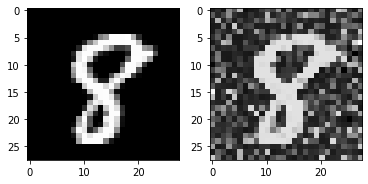

25  :  0.629385171012961 25
50  :  0.7165599189441207 25
75  :  0.7232243480560138 25
100  :  0.7089624812722165 25
125  :  0.7032612680236574 25
150  :  0.6987443745292938 25
175  :  0.7059137842373926 25
200  :  0.7085828486698396 25
225  :  0.7143834235904432 25
250  :  0.7143834235904432 25
275  :  0.715721453622951 25
300  :  0.7273719946733541 25
325  :  0.7235315966387428 25
350  :  0.7257967874156688 25
375  :  0.7307969457564703 25
400  :  0.7369291223916278 25
425  :  0.7391238456519179 25
450  :  0.7392382723847545 25
475  :  0.7408442868292501 25
500  :  0.7408442868292501 25
525  :  0.7410073842406144 25
550  :  0.7421046199130481 25
575  :  0.7445824211201799 25
600  :  0.7451806053161203 25
625  :  0.7460666132502477 25
650  :  0.7466845229496517 25
675  :  0.7484363878577717 25
700  :  0.7484159846874172 25
725  :  0.7495542747504574 25
750  :  0.7505288811611771 25
775  :  0.7507137786437494 25
800  :  0.7515171302727891 25
825  :  0.7523659553957888 25
850  :  0.75276

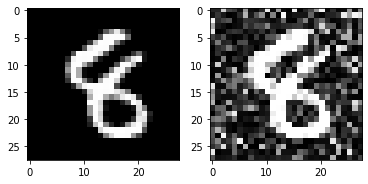

25  :  0.6983306671284528 25
50  :  0.7218948356130719 25
75  :  0.6775010316365049 25
100  :  0.7002146600820269 25
125  :  0.6878115998466331 25
150  :  0.6772792500534297 25
175  :  0.6806881086177972 25
200  :  0.6707390872874888 25
225  :  0.6727312196858526 25
250  :  0.6645980550211819 25
275  :  0.6699757002941897 25
300  :  0.6736181876692354 25
325  :  0.6699757002941897 25
350  :  0.6770799903341324 25
375  :  0.6752444587885651 25
400  :  0.6845374699499404 25
425  :  0.6879449600321331 25
450  :  0.7025516206077549 25
475  :  0.7052771052254704 25
500  :  0.7037194540383267 25
525  :  0.7037194540383267 25
550  :  0.7070411618103118 25
575  :  0.7062770870278566 25
600  :  0.7074024539165614 25
625  :  0.7068155505761813 25
650  :  0.70962027115941 25
675  :  0.7112857883246897 25
700  :  0.7125050507702457 25
725  :  0.7158643901600628 25
750  :  0.7206383960204259 25
775  :  0.7239520476634433 25
800  :  0.7239850689384286 25
825  :  0.7239850689384286 25
850  :  0.72398

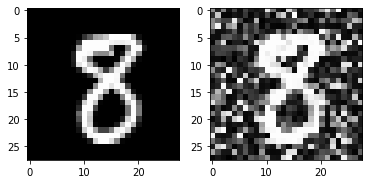

25  :  0.6170302749685563 25
50  :  0.6821334336949026 25
75  :  0.6758115108300083 25
100  :  0.6755346425830884 25
125  :  0.6627134875828871 25
150  :  0.6579487125980497 25
175  :  0.6500934826754358 25
200  :  0.6513875082332339 25
225  :  0.6614467054862898 25
250  :  0.6488433184303258 25
275  :  0.668575713026281 25
300  :  0.6707464981712727 25
325  :  0.6707464981712727 25
350  :  0.6937413538197876 25
375  :  0.6741051997778504 25
400  :  0.6775279521200293 25
425  :  0.6834583248975805 25
450  :  0.6834583248975805 25
475  :  0.6897496114893601 25
500  :  0.6898425417293963 25
525  :  0.6916431498375122 25
550  :  0.6916431498375122 25
575  :  0.6916431498375122 25
600  :  0.6936671288430831 25
625  :  0.6947955095436154 25
650  :  0.6962300523196204 25
675  :  0.6976156416895003 25
700  :  0.7008891253559872 25
725  :  0.7010159360120554 25
750  :  0.7020136132612635 25
775  :  0.7020136132612635 25
800  :  0.7035756985530848 25
825  :  0.706956757657982 25
850  :  0.70704

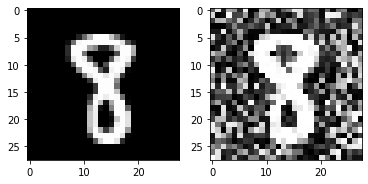

25  :  0.295116577119795 25
50  :  0.6339165691449347 25
75  :  0.4957462028900071 25
100  :  0.5053257438681164 25
125  :  0.5869002205947644 25
150  :  0.506732622634587 25
175  :  0.5845585157714773 25
200  :  0.6149104096740379 25
225  :  0.6133776586250714 25
250  :  0.6173769296532321 25
275  :  0.6511793261011362 25
300  :  0.6373956581975768 25
325  :  0.6373956581975768 25
350  :  0.6754571225178749 25
375  :  0.675033528835413 25
400  :  0.6735798329204842 25
425  :  0.6735798329204842 25
450  :  0.688878496351365 25
475  :  0.6854425716061763 25
500  :  0.6927837011811876 25
525  :  0.6979216909714843 25
550  :  0.6997647207693354 25
575  :  0.6997647207693354 25
600  :  0.7145346951327284 25
625  :  0.7175547264849331 25
650  :  0.7180755654103308 25
675  :  0.7219425809007713 25
700  :  0.7331507986315082 25
725  :  0.736697110258308 25
750  :  0.736697110258308 25
775  :  0.7389246394219661 25
800  :  0.7397464362214701 25
825  :  0.7423309279007454 25
850  :  0.742330927

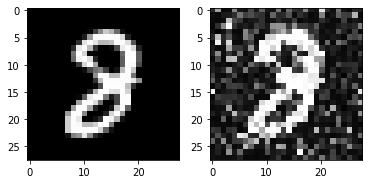

25  :  0.8527197730400267 25
50  :  0.8527197730400267 25
75  :  0.8369173743603079 25
100  :  0.8420370797000998 25
125  :  0.8256377604532041 25
150  :  0.8203388816621381 25
175  :  0.8035878675835246 25
200  :  0.7987161068263793 25
225  :  0.7974152128963827 25
250  :  0.8078002512743074 25
275  :  0.8177997015238081 25
300  :  0.8167294146373669 25
325  :  0.8167294146373669 25
350  :  0.8208959437567951 25
375  :  0.8244957622503916 25
400  :  0.8271767123361782 25
425  :  0.8257214015535146 25
450  :  0.8257214015535146 25
475  :  0.8257214015535146 25
500  :  0.8293036949988122 25
525  :  0.8277120520771775 25
550  :  0.8300208212367943 25
575  :  0.8331329945884225 25
600  :  0.8328267295472629 25
625  :  0.8357735223350442 25
650  :  0.836235583069733 25
675  :  0.8366370830167831 25
700  :  0.8375036856197354 25
725  :  0.8375036856197354 25
750  :  0.8375723198222846 25
775  :  0.8397720941055966 25
800  :  0.8397446107624408 25
825  :  0.8397446107624408 25
850  :  0.8398

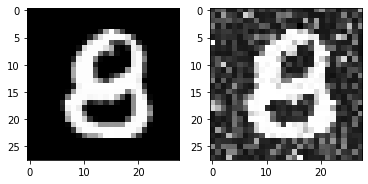

25  :  0.6430555865303511 25
50  :  0.7150281099645572 25
75  :  0.6986992649830805 25
100  :  0.7075047944125324 25
125  :  0.6965255523990377 25
150  :  0.48375427693788575 25
175  :  0.7107131703693148 25
200  :  0.6137382564614964 25
225  :  0.6861642699372497 25
250  :  0.11306817463492447 25
275  :  0.01327981994163735 25
300  :  0.6461168030734041 25
325  :  -0.1046183629867456 25
350  :  -0.10428005801348345 25
375  :  -0.1046107866043765 25
400  :  -0.1046107866043765 25
425  :  -0.1046107866043765 25
450  :  -0.1029017921352603 25
475  :  -0.1029017921352603 25
500  :  -0.10257588663657846 25
525  :  -0.1022625095400928 25
550  :  -0.1022625095400928 25
575  :  -0.10223952799410668 25
600  :  -0.10199079621500501 25
625  :  -0.10199079621500501 25
650  :  -0.10199079621500501 25
675  :  -0.10193129972955389 25
700  :  -0.10193129972955389 25
725  :  -0.10166716041487489 25
750  :  -0.10158146894540132 25
775  :  -0.10158146894540132 25
800  :  -0.10155463919371671 25
825  :  

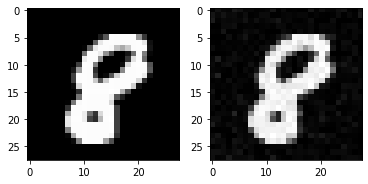

25  :  0.7342558477518805 25
50  :  0.7514584843291192 25
75  :  0.7280854459020927 25
100  :  0.7095062248886382 25
125  :  0.718267415188473 25
150  :  0.7052340258895206 25
175  :  0.7075318267188658 25
200  :  0.7098214289003637 25
225  :  0.7053722688759998 25
250  :  0.7071724634156354 25
275  :  0.7107110395520703 25
300  :  0.7178620702219798 25
325  :  0.7203653917291049 25
350  :  0.7220012827279843 25
375  :  0.7244491934819128 25
400  :  0.7268479602928815 25
425  :  0.7274940674852981 25
450  :  0.7290929759355832 25
475  :  0.7308335513833855 25
500  :  0.7322752649613521 25
525  :  0.7330560574325896 25
550  :  0.7350131450548884 25
575  :  0.7380469909988987 25
600  :  0.7387158436678859 25
625  :  0.7386121938582894 25
650  :  0.7388157945339886 25
675  :  0.7415044593863249 25
700  :  0.7426977957877673 25
725  :  0.7427574940092516 25
750  :  0.7432448863477857 25
775  :  0.7433408771612596 25
800  :  0.7436117849946634 25
825  :  0.7449864929407488 25
850  :  0.7451

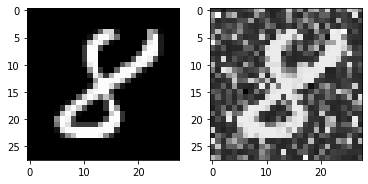

25  :  0.697614985802459 25
50  :  0.7103419350746714 25
75  :  0.5025743536962028 25
100  :  0.6028231386827718 25
125  :  0.6373484081904465 25
150  :  0.5726532274964053 25
175  :  0.6817610241331054 25
200  :  0.6602025964308703 25
225  :  0.034264047008965404 25
250  :  0.7021042480297299 25
275  :  0.7053335466291757 25
300  :  0.6991353833527387 25
325  :  0.3965252626842606 25
350  :  0.7011202332919668 25
375  :  0.6945674541496751 25
400  :  0.6890224590963744 25
425  :  0.6976739926094507 25
450  :  0.7110688253421268 25
475  :  0.6991914445936015 25
500  :  0.7110823931767589 25
525  :  0.7107417596000167 25
550  :  0.7208094246356411 25
575  :  0.7330302316902009 25
600  :  0.7217261592324796 25
625  :  0.7278634804919986 25
650  :  0.725747438875382 25
675  :  0.7252616297737268 25
700  :  0.7271209127928568 25
725  :  0.7295562472060111 25
750  :  0.7268676003130115 25
775  :  0.7271827870657558 25
800  :  0.7273554935426891 25
825  :  0.7276275047781885 25
850  :  0.729

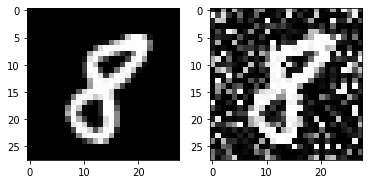

25  :  0.07970882389802425 25
50  :  0.19418662973613815 25
75  :  0.23149407594198657 25
100  :  0.2533219146543688 25
125  :  0.5614194259872337 25
150  :  0.46668675522261605 25
175  :  0.5847903901784954 25
200  :  0.57458573033296 25
225  :  0.6607113543639719 25
250  :  0.6274920645227291 25
275  :  0.6676407004491791 25
300  :  0.6825208846494732 25
325  :  0.6778539947219204 25
350  :  0.6746034694468039 25
375  :  0.6842998869700753 25
400  :  0.6898527652458081 25
425  :  0.6905941987273739 25
450  :  0.6961549996390748 25
475  :  0.7006668835861017 25
500  :  0.6923714504175803 25
525  :  0.6954351787610824 25
550  :  0.700665759235213 25
575  :  0.701911455494565 25
600  :  0.7016297068753037 25
625  :  0.7069853032944923 25
650  :  0.7052694812908962 25
675  :  0.7054799745725063 25
700  :  0.7047824062969317 25
725  :  0.7081860411476382 25
750  :  0.7082130596775947 25
775  :  0.7109754202343511 25
800  :  0.7113957131369858 25
825  :  0.7112686600592558 25
850  :  0.713

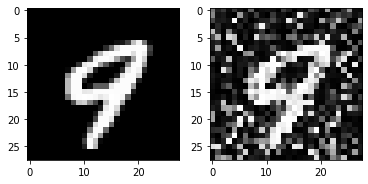

25  :  -0.1205061429991951 25
50  :  -0.12019194304651937 25
75  :  -0.11987340543146002 25
100  :  -0.11913364671895454 25
125  :  -0.12016713235122595 25
150  :  -0.1197362862449784 25
175  :  -0.11847169407151104 25
200  :  -0.11457316385620464 25
225  :  -0.11760354044127208 25
250  :  -0.11199699273369929 25
275  :  -0.10060644161027704 25
300  :  -0.056130877430510706 25
325  :  0.15125327803603678 25
350  :  0.5283451321153796 25
375  :  0.6261841412151128 25
400  :  0.6470133978166297 25
425  :  0.6369023896956918 25
450  :  0.6440077344284562 25
475  :  0.6477917249529745 25
500  :  0.6546636583927331 25
525  :  0.6596804533721984 25
550  :  0.669395794933084 25
575  :  0.672604283922274 25
600  :  0.6807582280136087 25
625  :  0.6813034631905731 25
650  :  0.6835286099744635 25
675  :  0.6816845920429853 25
700  :  0.6854031602641006 25
725  :  0.6904227815259377 25
750  :  0.6946257939271607 25
775  :  0.6954418687633246 25
800  :  0.6978473879577011 25
825  :  0.69719694639

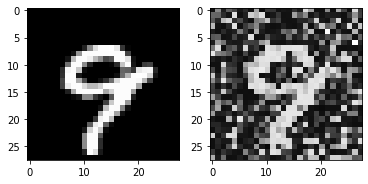

25  :  0.4821982542561159 25
50  :  0.670936142363905 25
75  :  0.662293505436998 25
100  :  0.6644613484530287 25
125  :  0.6847019349179738 25
150  :  0.6617186159802079 25
175  :  0.6836772091298028 25
200  :  0.6947009122886689 25
225  :  0.6976269780503351 25
250  :  0.704018134296023 25
275  :  0.7035930955704328 25
300  :  0.7060126562485436 25
325  :  0.7095151784670676 25
350  :  0.7130394077841433 25
375  :  0.7130394077841433 25
400  :  0.7130394077841433 25
425  :  0.7137601705386181 25
450  :  0.7150168421485448 25
475  :  0.7164281332546905 25
500  :  0.7179110180618522 25
525  :  0.7180834022247482 25
550  :  0.7199868285911013 25
575  :  0.7204229503368054 25
600  :  0.7205561741727325 25
625  :  0.721035196669255 25
650  :  0.7214162079379718 25
675  :  0.7236554304243865 25
700  :  0.7236689852806543 25
725  :  0.7246129042458971 25
750  :  0.7252905578836994 25
775  :  0.7252897133770153 25
800  :  0.7255793204655219 25
825  :  0.7260833416925054 25
850  :  0.7274989

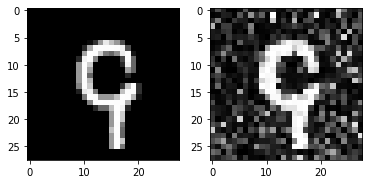

25  :  0.09178335529323817 25
50  :  0.09854715349093196 25
75  :  0.1651654633983869 25
100  :  0.2919585775214645 25
125  :  0.5237139740472931 25
150  :  0.5872210845761956 25
175  :  0.6660316028837757 25
200  :  0.7005669503251394 25
225  :  0.7107349466165567 25
250  :  0.7291988277815908 25
275  :  0.7320970934175264 25
300  :  0.736088570789456 25
325  :  0.7490920415541482 25
350  :  0.7509225217705133 25
375  :  0.7538521735315494 25
400  :  0.7593634584327645 25
425  :  0.7668168845543095 25
450  :  0.7749469394497228 25
475  :  0.7782743695955446 25
500  :  0.7778337121601288 25
525  :  0.7778337121601288 25
550  :  0.7784325867585165 25
575  :  0.7792084258636437 25
600  :  0.7792084258636437 25
625  :  0.7793730170834678 25
650  :  0.7816898828602176 25
675  :  0.7816898828602176 25
700  :  0.7824322785694664 25
725  :  0.7824322785694664 25
750  :  0.7824322785694664 25
775  :  0.7842755258669089 25
800  :  0.7856145038735456 25
825  :  0.7863207379229787 25
850  :  0.78

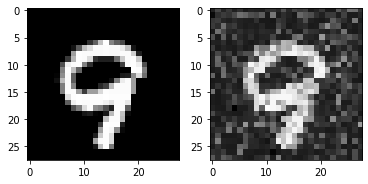

25  :  0.023809711140179213 25
50  :  0.5928464053408293 25
75  :  -0.06449662245647392 25
100  :  -0.05271353911701537 25
125  :  -0.025053889258074558 25
150  :  0.06624599855259272 25
175  :  0.1290286741405065 25
200  :  0.2568114474831155 25
225  :  0.43945330728944026 25
250  :  0.5931226217852945 25
275  :  0.6417766801369835 25
300  :  0.6525600537302781 25
325  :  0.6763754291515199 25
350  :  0.6763754291515199 25
375  :  0.6786310026733137 25
400  :  0.6834319200934611 25
425  :  0.6811606192961411 25
450  :  0.682413149258188 25
475  :  0.684830342605361 25
500  :  0.6884730043929138 25
525  :  0.6878167322896671 25
550  :  0.6980968373705085 25
575  :  0.6998383676765784 25
600  :  0.7063945050267217 25
625  :  0.7058604880006871 25
650  :  0.7058604880006871 25
675  :  0.7058604880006871 25
700  :  0.706540698967349 25
725  :  0.7084076667061915 25
750  :  0.7093684608680013 25
775  :  0.712947951859767 25
800  :  0.7129431706459014 25
825  :  0.7147911277179289 25
850  :

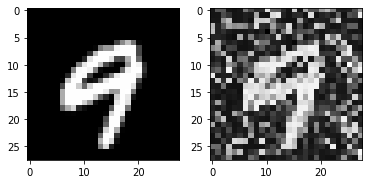

25  :  -0.11725303627317613 25
50  :  -0.11725303627317613 25
75  :  -0.11710468130216262 25
100  :  -0.11617226285160726 25
125  :  -0.08934384716540816 25
150  :  -0.07566674354911679 25
175  :  -0.0625236179939036 25
200  :  -6.2301519742069544e-06 25
225  :  0.1395146379221145 25
250  :  0.46579462966800705 25
275  :  0.5007318456065275 25
300  :  0.5593272273976109 25
325  :  0.5667922870807474 25
350  :  0.5802213358570659 25
375  :  0.5846229812380626 25
400  :  0.6117751731637987 25
425  :  0.6105352743260748 25
450  :  0.6245988692737657 25
475  :  0.6322205772018882 25
500  :  0.6711778926345473 25
525  :  0.6876815064713925 25
550  :  0.6876815064713925 25
575  :  0.6941519815294148 25
600  :  0.6960318773953815 25
625  :  0.6983702890167703 25
650  :  0.7034677501195159 25
675  :  0.7030430773312983 25
700  :  0.7047833788843244 25
725  :  0.7072726462511408 25
750  :  0.7089267120032259 25
775  :  0.7112817183366147 25
800  :  0.7101388940409799 25
825  :  0.71013889404097

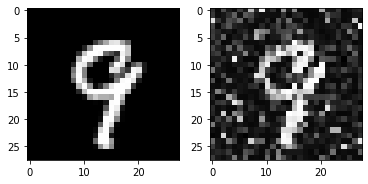

25  :  0.0020316041288328535 25
50  :  0.0687788787570027 25
75  :  0.37940934733505366 25
100  :  0.6095869607246509 25
125  :  0.6516847622499613 25
150  :  0.6516847622499613 25
175  :  0.662040072840024 25
200  :  0.662040072840024 25
225  :  0.6884529513508305 25
250  :  0.6884529513508305 25
275  :  0.6884529513508305 25
300  :  0.6905434306048892 25
325  :  0.7061911710216106 25
350  :  0.7083834071292251 25
375  :  0.7158858973194155 25
400  :  0.7158858973194155 25
425  :  0.7158858973194155 25
450  :  0.7158858973194155 25
475  :  0.7158858973194155 25
500  :  0.7158858973194155 25
525  :  0.7158858973194155 25
550  :  0.7167967988858049 25
575  :  0.7259010313260522 25
600  :  0.7266684911935866 25
625  :  0.7266684911935866 25
650  :  0.7266684911935866 25
675  :  0.7289104887408278 25
700  :  0.729069368211817 25
725  :  0.729069368211817 25
750  :  0.729069368211817 25
775  :  0.7324360946245909 25
800  :  0.7323864843954705 25
825  :  0.7323864843954705 25
850  :  0.7323

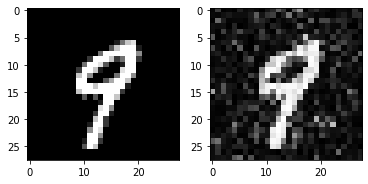

25  :  0.4835545398121819 25
50  :  0.6635369686977751 25
75  :  0.6054444455580742 25
100  :  0.6609585440717125 25
125  :  0.6502693361622124 25
150  :  0.6864285097390889 25
175  :  0.6731261363997583 25
200  :  0.6731261363997583 25
225  :  0.6843884289125022 25
250  :  0.6815277155483976 25
275  :  0.6904762887732088 25
300  :  0.6904762887732088 25
325  :  0.6904762887732088 25
350  :  0.6904957385736875 25
375  :  0.6904957385736875 25
400  :  0.6921444743677836 25
425  :  0.6922687152354425 25
450  :  0.6976934644215561 25
475  :  0.6978753391020935 25
500  :  0.6996399584045223 25
525  :  0.6996399584045223 25
550  :  0.7022336685429129 25
575  :  0.7032020585068903 25
600  :  0.7066231405561559 25
625  :  0.7063882336954908 25
650  :  0.7068117615320042 25
675  :  0.7072585654301341 25
700  :  0.709097447255218 25
725  :  0.7093931272579386 25
750  :  0.7098821651745606 25
775  :  0.7098821651745606 25
800  :  0.7121605114016701 25
825  :  0.7121605114016701 25
850  :  0.7121

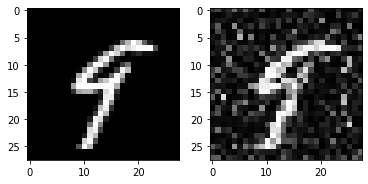

25  :  -0.1338285319723055 25
50  :  -0.1338285319723055 25
75  :  -0.1338249374744404 25
100  :  -0.1338285319723055 25
125  :  -0.1336095445098317 25
150  :  -0.1338285319723055 25
175  :  -0.13234362471579764 25
200  :  -0.13208940186543006 25
225  :  -0.13221061276352064 25
250  :  -0.13221061276352064 25
275  :  -0.13180414745747532 25
300  :  -0.13180414745747532 25
325  :  -0.1312512534687688 25
350  :  -0.1309074472504751 25
375  :  -0.13098271267186173 25
400  :  -0.13098271267186173 25
425  :  -0.13098271267186173 25
450  :  -0.13098271267186173 25
475  :  -0.13098271267186173 25
500  :  -0.13098271267186173 25
525  :  -0.13065643793966758 25
550  :  -0.13042107442773887 25
575  :  -0.13031398421292817 25
600  :  -0.1303428964973215 25
625  :  -0.12998693717168958 25
650  :  -0.1297645442095507 25
675  :  -0.12976497334782516 25
700  :  -0.1297563878425767 25
725  :  -0.1297316497892701 25
750  :  -0.12929339906059562 25
775  :  -0.12931157000329996 25
800  :  -0.129311570003

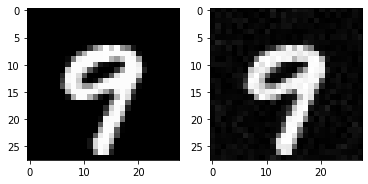

25  :  -0.025562008593816965 25
50  :  0.04965337108507234 25
75  :  0.16111285083607876 25
100  :  0.2855519288998594 25
125  :  0.4639248142701472 25
150  :  0.4937173762747242 25
175  :  0.6232365406731504 25
200  :  0.6617694608847989 25
225  :  0.6750885753714827 25
250  :  0.6750885753714827 25
275  :  0.6825451181173992 25
300  :  0.688073201871458 25
325  :  0.6962191654352442 25
350  :  0.7033950687176178 25
375  :  0.7038339464965837 25
400  :  0.7038339464965837 25
425  :  0.7047851651251332 25
450  :  0.7069547520907591 25
475  :  0.7081654716076297 25
500  :  0.7084518249169482 25
525  :  0.7084518249169482 25
550  :  0.7101607388672737 25
575  :  0.7113082728520241 25
600  :  0.7113082728520241 25
625  :  0.7113241826470619 25
650  :  0.7120154234536062 25
675  :  0.7128388648777303 25
700  :  0.7129040583974532 25
725  :  0.7135277096734596 25
750  :  0.7147846618935368 25
775  :  0.7151984675094116 25
800  :  0.7160562066447766 25
825  :  0.7161219989972367 25
850  :  0

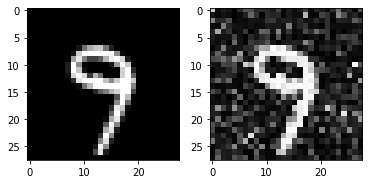

25  :  0.7781516709617843 25
50  :  0.7937658905979341 25
75  :  0.7407602230247631 25
100  :  0.7687199528260685 25
125  :  0.7578255542573624 25
150  :  0.7844228731365881 25
175  :  0.7816566512917844 25
200  :  0.7818872148095919 25
225  :  0.7816566512917844 25
250  :  0.7863837308525856 25
275  :  0.7889102287739851 25
300  :  0.790121175429858 25
325  :  0.7902751632960583 25
350  :  0.7915198329882165 25
375  :  0.7917075823885371 25
400  :  0.7928943524999387 25
425  :  0.7965137892195389 25
450  :  0.7972509399243068 25
475  :  0.7976350568103437 25
500  :  0.7998152377860568 25
525  :  0.7998575823737248 25
550  :  0.8008951037545169 25
575  :  0.8024581593413935 25
600  :  0.8024560841937702 25
625  :  0.8030074535228127 25
650  :  0.8035346093974671 25
675  :  0.8047183682420481 25
700  :  0.8052997973026554 25
725  :  0.8058851435955687 25
750  :  0.8064078875551515 25
775  :  0.8067621199008175 25
800  :  0.8070880672322118 25
825  :  0.8072054668189361 25
850  :  0.8072

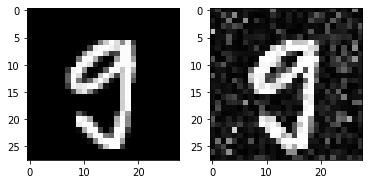

25  :  -0.09459069579145635 25
50  :  -0.09204338528428524 25
75  :  -0.060957531507190355 25
100  :  -0.053921217015622636 25
125  :  -0.00023924843914885363 25
150  :  0.20053670604306983 25
175  :  0.4453968854599111 25
200  :  0.6639909838606752 25
225  :  0.6784978329397212 25
250  :  0.6853458442694238 25
275  :  0.6853458442694238 25
300  :  0.6958666588919953 25
325  :  0.7011869233227388 25
350  :  0.709658642509454 25
375  :  0.7170280049502485 25
400  :  0.7273857404100159 25
425  :  0.7272352243173477 25
450  :  0.7281014767106515 25
475  :  0.731533196126242 25
500  :  0.7366117921763944 25
525  :  0.7366117921763944 25
550  :  0.7377355469487686 25
575  :  0.7402886938037282 25
600  :  0.7464715314788577 25
625  :  0.7467732112123198 25
650  :  0.7467732112123198 25
675  :  0.7471923417859647 25
700  :  0.7518935940517304 25
725  :  0.7532633972981072 25
750  :  0.753003738306709 25
775  :  0.7539517670483109 25
800  :  0.7576183444925937 25
825  :  0.7576840470307331 25


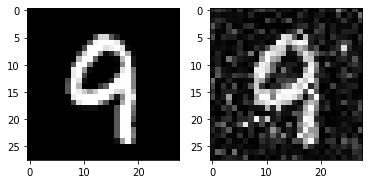

25  :  0.00269595301901121 25
50  :  0.08505030771476263 25
75  :  0.12974179132057456 25
100  :  0.06050465158730317 25
125  :  0.03189100856454402 25
150  :  0.4653281151395765 25
175  :  0.3917763234319387 25
200  :  0.5994657260254812 25
225  :  0.5283961661324807 25
250  :  0.6617144586041757 25
275  :  0.702104820097469 25
300  :  0.6976480708966395 25
325  :  0.7003875435311068 25
350  :  0.7042266270715768 25
375  :  0.7067198335899902 25
400  :  0.7142360599037842 25
425  :  0.7135568615932895 25
450  :  0.7137739990268593 25
475  :  0.7144895310735973 25
500  :  0.7144895310735973 25
525  :  0.7204822065365517 25
550  :  0.7211304663396225 25
575  :  0.7210995165419705 25
600  :  0.7215408700893132 25
625  :  0.7240278134377811 25
650  :  0.7239086386418081 25
675  :  0.7242467608573981 25
700  :  0.7252029534456736 25
725  :  0.7261953400730854 25
750  :  0.726211937339116 25
775  :  0.7270176221997457 25
800  :  0.7270864500822556 25
825  :  0.7272729019809273 25
850  :  0.

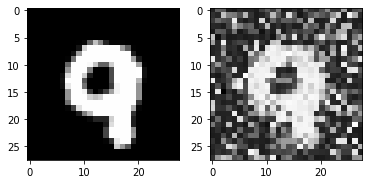

In [9]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28*28) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_rbf_mnist_ssim_seed1', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [11]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

197.09018301963806
83.6707227230072
123.09737809120662
23.088421887213766


In [12]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

1839
800
1114.595238095238
213.06814539132515


In [13]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

28.600575351494896
7.348340961196264
15.103713727970694
5.702655987139017
